<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TestingNVPExtensionGaussianLikelihood_Hessians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [3]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     | 10.6MB 6.6MB/s


In [0]:
import corner

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0514 05:22:12.064862 140613639006080 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [6]:
generator_path   = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path     ='./gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path    = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
plot_path        = './gdrive/My Drive/MPM/modules/gauss3b/plots/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final4/

assets	saved_model.pb	tfhub_module.pb  variables


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [9]:
#finding EL2O 'by hand'
tf.reset_default_graph()


batch_size  = 64
hidden_size = 10
sigma_n     = 0.1
n_channels  = 1
data_dim    = 28*28

sample_size_z = 64
lr            = tf.placeholder_with_default(0.001,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

def get_prior():
  return tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0, name ='prior')

prior = get_prior()

# ----------------------------------------------------------#


# uncorrupted data

prior_samples = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

x_tr          = tf.placeholder(shape=[batch_size,data_dim,n_channels], dtype=tf.float32)

encoded_data  = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma     = tf.split(encoded_data, 2, axis=-1)
sigma         = tf.nn.softplus(sigma) + 0.0001

approx_posterior_vae = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[-1,data_dim,1])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood_vae.mean()

#test sample from prior
prior_sample      = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_samples),[-1,data_dim,n_channels])

sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()

# ----------------------------------------------------------#



# -----------train NVP ----------------------#

# nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
# 

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = get_prior()
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])

# opt_op_nvp= optimizer.minimize(loss)

# -----------train NVP ----------------------#


#load NVP 
nvp_funcs     = hub.Module(nvp_func_path, trainable=False)


nvp_prior     = tf.placeholder_with_default(True,shape=[])

# ------------------- corrupted data -------------------#

# for corrupted data
batch_size2   = 1
sigma_corr    = tf.placeholder_with_default(np.ones([batch_size2,data_dim,n_channels], dtype='float32')*sigma_n,shape=[batch_size2,784,n_channels])
x_corr        = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

# encoded truth
x_ul          = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

encoded_x     = encoder(tf.reshape(x_ul,[-1,28,28,n_channels]))
mu_x, sigma_x = tf.split(encoded_x, 2, axis=-1)



# ------- mean field VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)
sigma_elbo_    = tf.nn.softplus(sigma_elbo) + 0.0001

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo_, name='approxposterior_elbo')

kl_divergence     = tfd.kl_divergence(approx_posterior_elbo, prior) 
zz_               = approx_posterior_elbo.sample()
fwd_zz_           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_},as_dict=True)['fwd_pass'], lambda: zz_)
elbo_liklogits    = tf.reshape(generator(fwd_zz_),[-1,data_dim,n_channels])
corr_likelihood   = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits,scale_diag=sigma_corr))
elbo              = -tf.reduce_mean(corr_likelihood.log_prob(x_corr)- kl_divergence,axis=0)

opt_op_elbo       = optimizer.minimize(elbo,var_list=[mu_elbo,sigma_elbo])

mu_elbo_              = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_elbo},as_dict=True)['fwd_pass'], lambda: mu_elbo)
mu_liklogits          = tf.reshape(generator(mu_elbo_),[-1,data_dim,n_channels])
mean_corr_likelihood  = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_liklogits,scale_diag=sigma_corr)).mean()

samples_post_elbo     = tf.reshape(approx_posterior_elbo.sample(sample_size_z),[-1,hidden_size])
samples_post_elbo     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':samples_post_elbo},as_dict=True)['fwd_pass'], lambda: samples_post_elbo)
sample_elbo_liklogits = tf.reshape(generator(tf.reshape(samples_post_elbo,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean      = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits,scale_diag=sigma_corr)).mean()

# ------- mean field VI on corrupted data ---------------#

# ------- full rank VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo_full_rank"):
  mu_f_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size), dtype=np.float32), dtype=np.float32)
  sigma_f_elbo   = tf.Variable(np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32), dtype=tf.float32)

sigma_f_elbo_t = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_f_elbo), transform=tf.nn.softplus)

approx_posterior_f_elbo = tfd.MultivariateNormalTriL(loc=mu_f_elbo,scale_tril=sigma_f_elbo_t)


kl_divergence_f    = tfd.kl_divergence(approx_posterior_f_elbo, prior) 
zz_f               = approx_posterior_f_elbo.sample()
fwd_zz_f           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_f},as_dict=True)['fwd_pass'], lambda: zz_f)
elbo_liklogits_f   = tf.reshape(generator(fwd_zz_f),[-1,data_dim,n_channels])
corr_likelihood_f  = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits_f,scale_diag=sigma_corr))
elbo_f             = -tf.reduce_mean(corr_likelihood_f.log_prob(x_corr)- kl_divergence_f,axis=0)

opt_op_elbo_f      = optimizer.minimize(elbo_f,var_list=[mu_f_elbo,sigma_f_elbo])

# likelihood of posterior mean
mu_elbo_f_             = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_f_elbo},as_dict=True)['fwd_pass'], lambda: mu_f_elbo)
mu_f_liklogits         = tf.reshape(generator(mu_elbo_f_),[-1,data_dim,n_channels])
mean_corr_likelihood_f = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_f_liklogits,scale_diag=sigma_corr)).mean()
sample_post_elbo_f     = tf.reshape(approx_posterior_f_elbo.sample(sample_size_z),[-1,hidden_size])
sample_post_elbo_f     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':sample_post_elbo_f},as_dict=True)['fwd_pass'], lambda: sample_post_elbo_f)
sample_elbo_liklogits_f= tf.reshape(generator(tf.reshape(sample_post_elbo_f,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean_f     = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits_f,scale_diag=sigma_corr)).mean()

# ------- full rank VI on corrupted data ---------------#



#### for naive recon and strating MAP finding at truth


### estimate the MAP for ###
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size2,hidden_size]),shape=[batch_size2,hidden_size])
MAP                  = tf.Variable(MAP_ini)

MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

fwd_MAP              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
genMAP               = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size2,data_dim,n_channels])

likeli_MAP           = tfd.Independent(tfd.MultivariateNormalDiag(loc=genMAP,scale_diag=sigma_corr))

likeli_log_prob      = likeli_MAP.log_prob(x_corr)

prior_MAP            = prior.log_prob(MAP)

posterior_MAP        = prior_MAP+likeli_log_prob

loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op_MAP           = optimizer.minimize(loss_MAP, var_list=[MAP])



##### ----------  do Laplace approximation ----------- #####
true_hess  = tf.placeholder_with_default(True,shape=[])
diag_hess  = tf.placeholder_with_default(False,shape=[])


ini_val  = np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float64)
with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size2,hidden_size),dtype=np.float32), dtype=np.float64)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float64)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)



# this is exact hessian computation 
hess             = tf.hessians(-posterior_MAP,MAP)
hess             = tf.gather(hess, 0)
hess2            = tf.reduce_sum(hess, axis = 2 )

# constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)

grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size2],dtype=tf.float32)

hess_approx      = one+grad_g2

eig1             = tf.cond(true_hess, lambda: tf.linalg.eigvalsh(hess2), lambda: tf.linalg.eigvalsh(hess_approx))

sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(tf.cast(hess2,tf.float64)), lambda: tf.linalg.inv(tf.cast(hess_approx,tf.float64)))

scale            = tf.placeholder_with_default(1.,shape=[])

#allow for cooling
sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))*tf.cast(scale, tf.float64)

# try taking only the diagonal
sigma_diag       = tf.expand_dims(tf.linalg.tensor_diag(tf.linalg.diag_part(sigma_hess[0])),0)

eig2             = tf.linalg.eigvalsh(sigma_hess)

sigma_hess_      = tf.cond(diag_hess, lambda: tf.linalg.cholesky(sigma_diag), lambda: tf.linalg.cholesky(sigma_hess))

MAP_             = tf.cast(MAP, tf.float64)
update2          = mu_new.assign(MAP_)
update3          = sigma_new_t2.assign(sigma_hess_)

log_det          = tf.linalg.logdet(approx_posterior_laplace.covariance())

# evaluation
lap_z_samples     = tf.cast(tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size]),dtype=tf.float32)
fwd_zs            = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':lap_z_samples},as_dict=True)['fwd_pass'], lambda:lap_z_samples) 
lap_liklogits     = tf.reshape(generator(fwd_zs),[-1,784,n_channels])
lap_likelihood    = tfd.Independent(tfd.MultivariateNormalDiag(loc=lap_liklogits,scale_diag=sigma_corr))
lap_mean          = lap_likelihood.mean()
lapl_variance_MAP = tf.linalg.diag_part(approx_posterior_laplace.covariance())

# minimize elbo with mu fixed at MAP, make sure nvp prior is set correctly
update4           = mu_elbo.assign(MAP_ini)
opt_op_elbo2      = optimizer.minimize(elbo,var_list=[sigma_elbo])


# minimize elbo_f with mu fixed at MAP, make sure nvp prior is set correctly
update5           = mu_f_elbo.assign(MAP_ini)
opt_op_elbo2f     = optimizer.minimize(elbo_f,var_list=[sigma_f_elbo])

num_chains =20

def unnormalized_log_prob(x):
  
  fwd_x              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':x},as_dict=True)['fwd_pass']

  # option to use uncorrected latent space
  gen_x              = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_x), lambda: generator(x)),[num_chains,data_dim,n_channels])

  likeli_x           = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_x,scale_diag=sigma_corr))

  likeli_log_prob_x  = likeli_x.log_prob(x_corr)

  prior_x            = prior.log_prob(x)

  posterior_x        = prior_x+likeli_log_prob_x

  return posterior_x


#### ----- this is an hmc sampler------------#

# Create state to hold updated `step_size`.
step_size = tf.get_variable(
    name='step_size',
    initializer=np.ones((num_chains,hidden_size),dtype=np.float32)*1.,
    use_resource=True,  # For TFE compatibility.
    trainable=False)



ini_chain = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)
# Initialize the HMC transition kernel.
num_results = int(2e4)
num_burnin_steps = int(2e3)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_log_prob,
    num_leapfrog_steps=3,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=int(num_burnin_steps * 0.8)))

# Run the chain (with burn-in).
hmc_samples, hmc_kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_steps_between_results=10,
    num_burnin_steps=num_burnin_steps,
    current_state=ini_chain,
    kernel=hmc)
#### ----- this is an hmc sampler------------#

#### ----- this is a a Random Walk Metropolis Hastings------------#

# Initial state of the chain
init_state = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)

# Run Random Walk Metropolis with normal proposal for `num_results`
# iterations for `num_chains` independent chains:
mcmc_samples, mcmc_stats = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_log_prob,
        seed=54,
        new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1,name=None)),
    num_burnin_steps=num_burnin_steps,
    num_steps_between_results=10,  # Thinning.
    parallel_iterations=1)


# # # construct a GMM approximation from different minima
num_comp = 1
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((batch_size2,num_comp,hidden_size)), dtype=np.float32)
  ini_val2    = np.ones((batch_size2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
  sigma_gmm   = tf.constant(ini_val2)
  sigma_gmmt  = tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_gmm), transform=tf.nn.softplus))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

mu_est        = tf.placeholder_with_default(tf.zeros([batch_size2,num_comp,hidden_size]),shape=[batch_size2,num_comp,hidden_size])
sigma_est     = tf.placeholder_with_default(tf.ones([batch_size2,num_comp,hidden_size, hidden_size]),shape=[batch_size2,num_comp,hidden_size, hidden_size])
w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_a      = w_gmm.assign(w_est)
update_b      = mu_gmm.assign(mu_est)
update_c      = sigma_gmmt.assign(sigma_est)

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

gmm_sample_z  = tf.squeeze(gmm.sample(sample_size_z))
gmm_fwd       = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample_z},as_dict=True)['fwd_pass'], lambda:gmm_sample_z)
gmm_fwd       = tf.reshape(generator(gmm_fwd),[-1,data_dim,1])
gmm_sample_x  =tfd.Independent(tfd.MultivariateNormalDiag(loc=gmm_fwd,scale_diag=sigma_corr)).mean()

# saver         = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.


W0514 05:22:17.320546 140613639006080 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:17.517105 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:17.566155 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:17.820293 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:18.550728 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:18.937584 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:19.010093 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.cast instead.


W0514 05:22:19.087697 140613639006080 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:20.258611 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:20.348496 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:20.941942 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:21.047507 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:21.521268 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:21.628550 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:22.980534 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:23.104005 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:23.554898 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:23.686651 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:24.314083 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:24.463962 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:24.562594 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:28.098839 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:28.271599 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:29.967996 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:30.165398 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:30.318735 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:32.892298 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:33.148416 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:33.338009 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:35.343181 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:35.593016 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:35.790359 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:36.516586 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:36.785504 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:36.995344 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.random.categorical instead.


W0514 05:22:37.430439 140613639006080 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/categorical.py:263: multinomial (from tensorflow.python.ops.random_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.random.categorical instead.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:37.932037 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 05:22:38.225925 140613639006080 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Reconstruct uncorrupted test data and inspect samples**

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

(64, 784, 1)
(64, 784, 1)


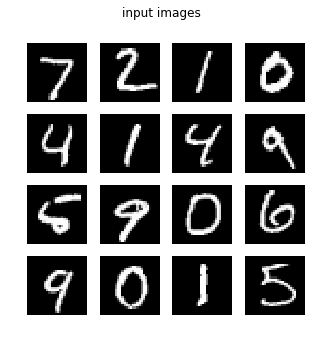

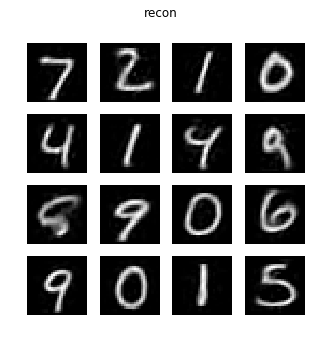

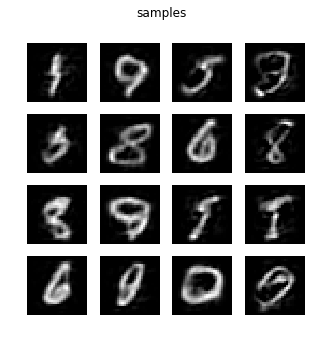

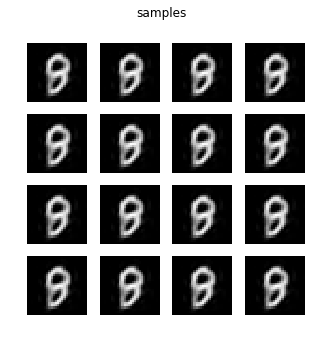

In [12]:
p_samples = sess.run(prior_sample)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('recon')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
p_samples = np.zeros_like(p_samples)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})

print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

**Fit NVP to posterior for better samples**

In [0]:
# nvp_loss = []
# ii     = 0
# nepoch = 0
# learning_rate = 1e-3

In [0]:
# #train the nvp
# while nepoch<1000:
#   if (ii+1)*batch_size>len(x_train): 
#     np.random.shuffle(x_train)
#     ii=0
#     nepoch+=1
#     print('starting epoch', nepoch)
#   if nepoch>10:
#     learning_rate=1e-5
#   if nepoch>200:
#     learning_rate=1e-6
#   x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
#   _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
#   nvp_loss+=[ll]
#   if ii%500==0:
#     print(ll)
#   ii+=1

In [0]:
# plt.figure()
# plot(nvp_loss[::],label='nvp loss')
# legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 00:01:25.966770 140526495975296 saver.py:1483] Saver not created because there are no variables in the graph to restore


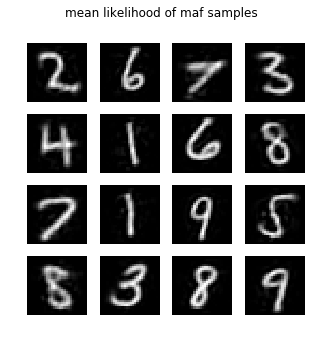

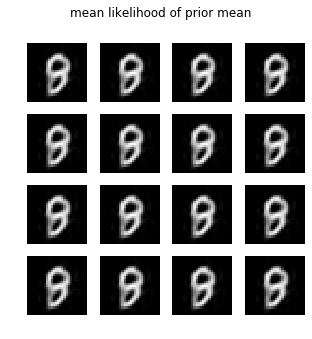

In [147]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_samples: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
    
s = sess.run(sample_mean, feed_dict={prior_samples: np.zeros_like(samples1)})

figure(figsize=(5,5))
suptitle('mean likelihood of prior mean')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [13]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 04:53:53.923635 139941427271552 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


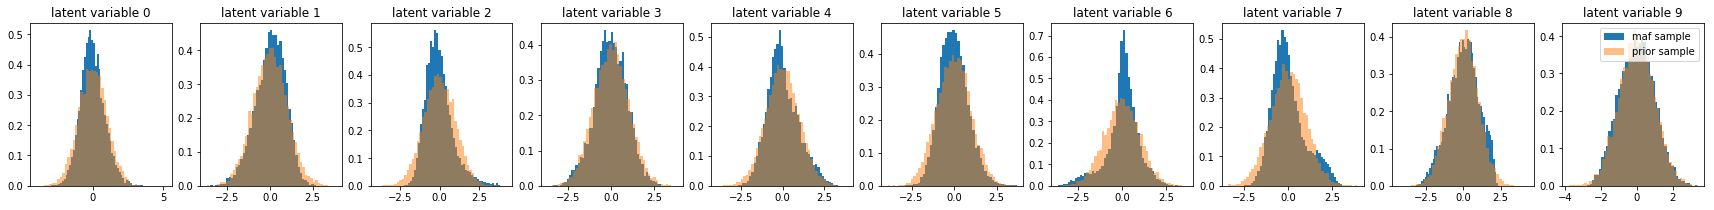

In [14]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

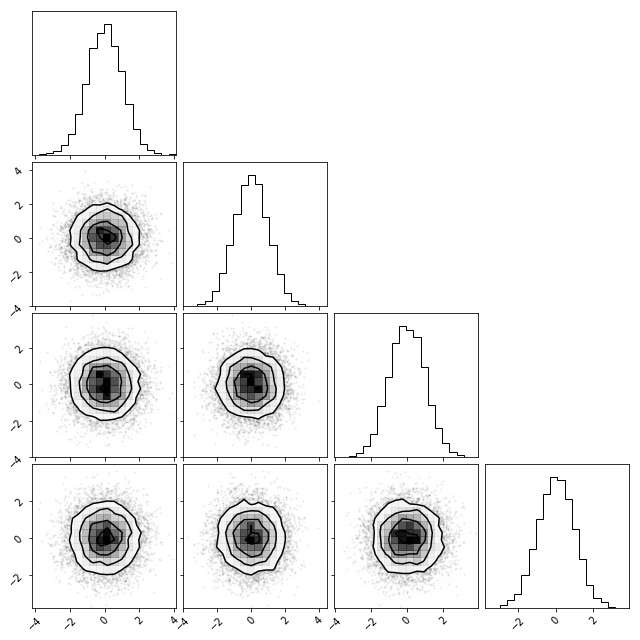

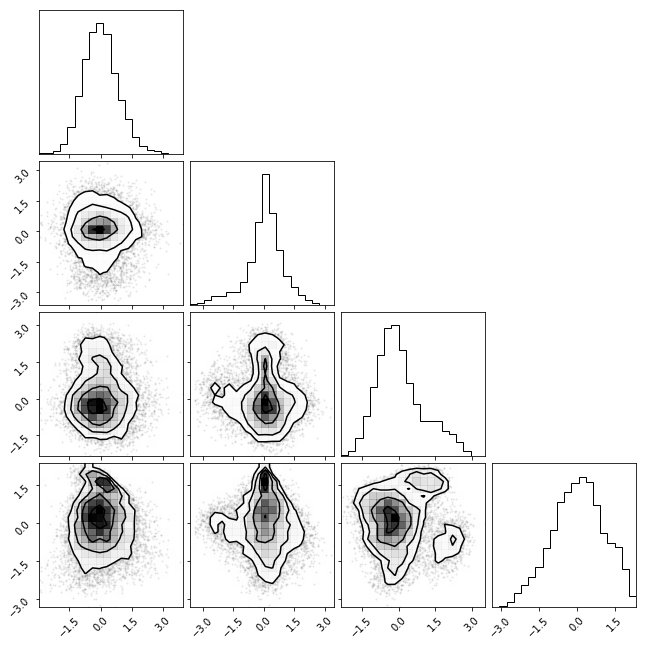

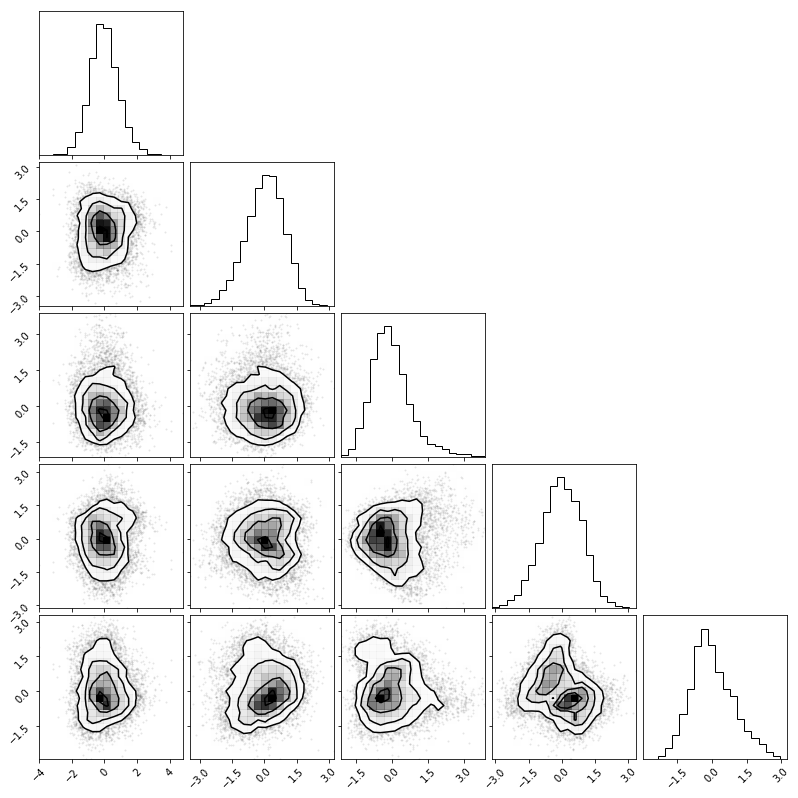

In [150]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])
_ = corner.corner(maf_s[:,0:5])

**Make corrupted data**

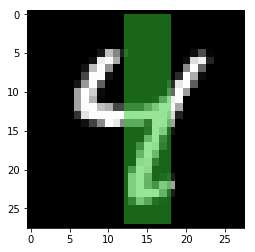

In [11]:

mask = np.ones(IMAGE_SHAPE, dtype=int)
# use also 12:18/12:20 -> 4 
minx = 12
maxx = 18#20
mask[0:28,minx:maxx]=0.
mask = mask.reshape((28*28))
sigma_new = np.ones(mask.shape)*sigma_n
sigma_new[np.where(mask==0)] = sigma_n*1e4
x_true = x_test[6:6+batch_size2]
masked_data = x_true*[mask]
sigma_new = np.asarray([np.expand_dims(sigma_new,-1)]*batch_size2)

data = np.expand_dims(masked_data,-1)
plt.figure()
_=plt.imshow(x_true.reshape((28,28)),cmap='gray',vmin=0)
x = np.arange(28)
plt.fill_between(x, 0, 27, where=[(x>=minx)*(x<=maxx)][0] ,facecolor='limegreen', alpha=0.5)
plt.show()


**Minimize ELBO for corrupted data and look at samples**

A) mean field

In [0]:
posterior_loss=[]

In [20]:
lrate=1e-4
for ii in range(8000):
  if ii >4000:
    lrate=1e-5
  _, ll = sess.run([opt_op_elbo, elbo],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%100==0:
    print(ll)

760.0963
762.90063
762.8226
759.70984
758.9614
765.2818
764.86554
757.4689
758.6214
761.6785
758.1258
758.16364
760.3949
759.78973
763.96643
759.20996
762.06476
762.2116
758.6801
758.1413
759.95856
761.4288
761.6316
759.8191
761.16205
760.2508
766.1803
761.5504
762.6842
765.77356
762.61633
762.37775
759.3806
766.5229
763.84863
760.12146
760.0307
762.955
762.8192
764.63617
762.98
759.80115
763.92706
760.16077
765.1362
762.9025
759.8173
759.4445
767.7081
763.9503
764.1293
760.423
759.6307
762.16376
761.93024
761.73267
766.59503
760.17883
766.21497
764.94507
761.0458
765.44556
783.5928
760.43884
759.2405
761.09735
760.45953
761.3059
763.0532
759.332
759.60187
763.94116
798.77423
759.5143
769.95404
762.74744
759.53687
759.63684
758.54395
761.2218


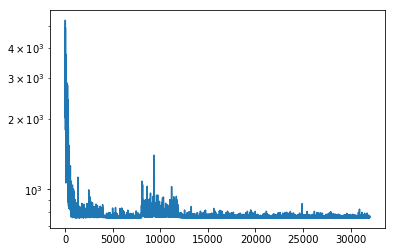

In [21]:
plt.plot(posterior_loss)
yscale('log')

In [22]:
mean    = sess.run(mean_corr_likelihood,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

VI_mean, VI_cov = sess.run([approx_posterior_elbo.mean(),approx_posterior_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss     = sess.run(approx_posterior_elbo.log_prob(VI_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss = - VI_min_loss
print(VI_mean,VI_min_loss)

[[ 3.048477   -0.1745272  -0.76997507  0.800691    0.8757721   0.9332883
  -0.12091929 -2.7391825   1.0163354  -0.38771686]] [-23.417053]


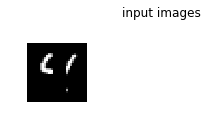

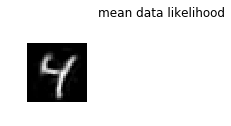

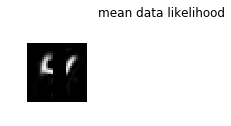

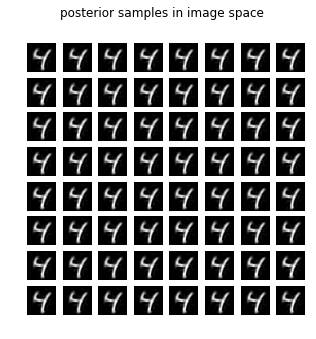

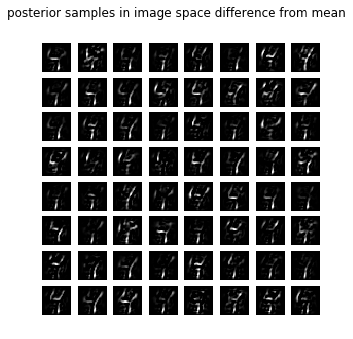

In [23]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]-mean_sample,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.show()

In [0]:

import pickle
try:
  VI_mean, VI_cov, VI_loss = pickle.load(open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([VI_mean, VI_cov, VI_min_loss],open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))


B) full rank

In [0]:
posterior_loss=[]
#sess.run([reset_elbo, reset_elbo2],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

In [56]:
lrate=1e-3
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo_f, elbo_f],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%100==0:
    print(ll)

757.1579
762.3702
754.49054
755.0839
755.74036
757.17505
756.13434
752.5444
755.0161
758.9142
756.1469
751.937
754.76733
754.2954
756.88904
756.16376
759.1558
752.6025
754.96954
757.9594


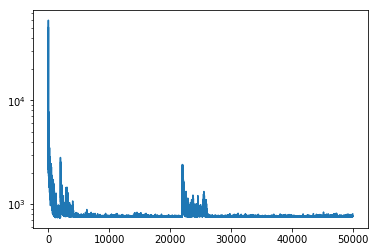

In [57]:
plt.plot(posterior_loss)
yscale('log')

In [58]:
mean   = sess.run(mean_corr_likelihood_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_mean, VI_f_cov = sess.run([approx_posterior_f_elbo.mean(),approx_posterior_f_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = sess.run(approx_posterior_f_elbo.log_prob(VI_f_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = -VI_f_min_loss
print(VI_f_mean,VI_f_min_loss)

[[ 3.1794155   0.05286769 -0.8153495   0.8948751   0.96632504  0.9690792
  -0.1355044  -2.9155207   1.0829648  -0.42484915]] [-17.737171]


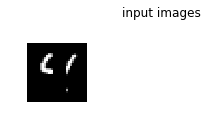

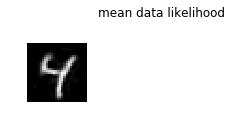

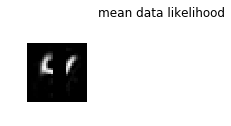

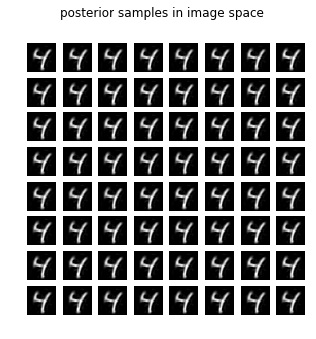

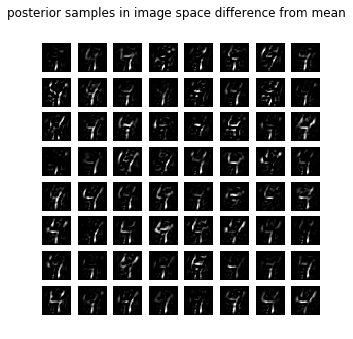

In [59]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]-mean_sample,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.show()

In [0]:
# try:
#   VI_f_mean, VI_f_cov,VI_f_min_loss = pickle.load(open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
# except:
pickle.dump([VI_f_mean, VI_f_cov,VI_f_min_loss],open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))

**find minima with nvp**

0
2664.5308
-540.5846
-537.52826
-537.1068
-552.59283
-551.55347
-548.1741
-537.65717
-550.98035
-544.7386
switching to lr 0.01
-537.33234
-553.53503
-554.07117
-553.8858
-553.5018
switching to lr 0.001
-553.95056
-554.34607
1
2377.998
-546.31165
-550.8979
-534.36304
-535.9138
-552.4225
-547.7569
-548.29346
-551.26544
-550.7053
switching to lr 0.01
-548.724
-554.235
-554.34076
-554.35175
-554.3181
switching to lr 0.001
-554.20325
-554.54865
2
2869.3655
592.6626
593.71484
594.02515
592.8959
595.11426
593.41156
593.7044
594.1989
593.7993
switching to lr 0.01
594.80927
592.086
592.1321
592.0856
592.3293
switching to lr 0.001
592.31744
592.0685
3
2613.011
-550.2405
-553.79224
-553.6528
-550.85126
-551.01953
-551.143
-549.3841
-547.41077
-527.67487
switching to lr 0.01
-552.28674
-554.4813
-554.482
-554.4783
-554.43555
switching to lr 0.001
-554.3027
-554.58185
4
2220.4812
-407.8797
-531.5133
-528.4289
-542.73254
-540.21844
-552.8095
-553.2285
-550.7041
-545.97235
switching to lr 0.01
-553.

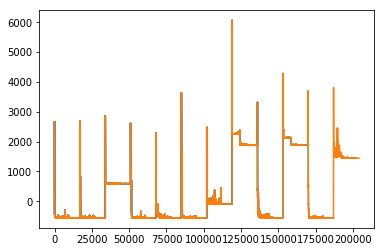

In [61]:
posterior_corr_loss=[]

l_minima=[]
map_minima=[]
for ii in range(12):
  print(ii)
  if ii ==1:
    ini = np.zeros((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))+1e-8
  elif ii==0:
    #starting from truth
    ini = sess.run(mu_x,feed_dict={x_ul: np.expand_dims(x_true,-1)})
  else:
    ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  print('switching to lr', lrate)
  for ii in range(5000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for ii in range(2000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  plot(posterior_corr_loss,label='data_loss')
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new})]

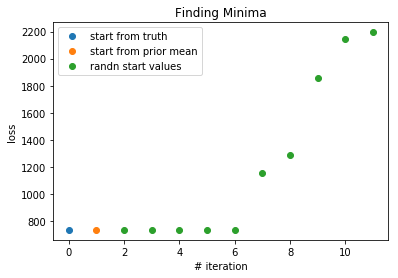

In [62]:
plt.figure()
plt.title('Finding Minima')
plt.plot(0,l_minima[0],ls='',marker='o',label='start from truth')
plt.plot(1,l_minima[1],ls='',marker='o',label='start from prior mean')
plt.plot(np.arange(len(l_minima)-2)+2,l_minima[2::],ls='',marker='o', label='randn start values')
plt.xlabel('# iteration')
plt.ylabel('loss')
plt.legend()
plt.savefig(plot_path+'minimzation_results_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')

plt.show()

In [0]:
import pickle
try:
  l_minima,map_minima = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([l_minima,map_minima],open(minima_path+'nvp_minima_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))
  
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)

In [84]:
print(map_minima[0])
print(VI_f_mean)
print(VI_mean)

[[[ 2.9024656  -1.6743604  -0.2593242   1.6918569   0.37850964
    0.22731519 -0.59498364 -2.2878501   0.44258544 -0.71237904]]]
[[ 2.990764   -1.6138238  -0.19748013  1.6091464   0.38681075  0.2148613
  -0.5958463  -2.2618341   0.44555804 -0.80783   ]]
[[ 3.0361474  -1.6496364  -0.14577852  1.7053449   0.43219635  0.16960318
  -0.6008079  -2.2785141   0.44139946 -0.8040187 ]]


**Sample posterior of (un)corrupted data**

In [0]:
samples_mcmc, mcmc_stats_ = sess.run([mcmc_samples,mcmc_stats],feed_dict={x_corr: np.expand_dims(masked_data,-1),sigma_corr:sigma_new, nvp_prior:True})

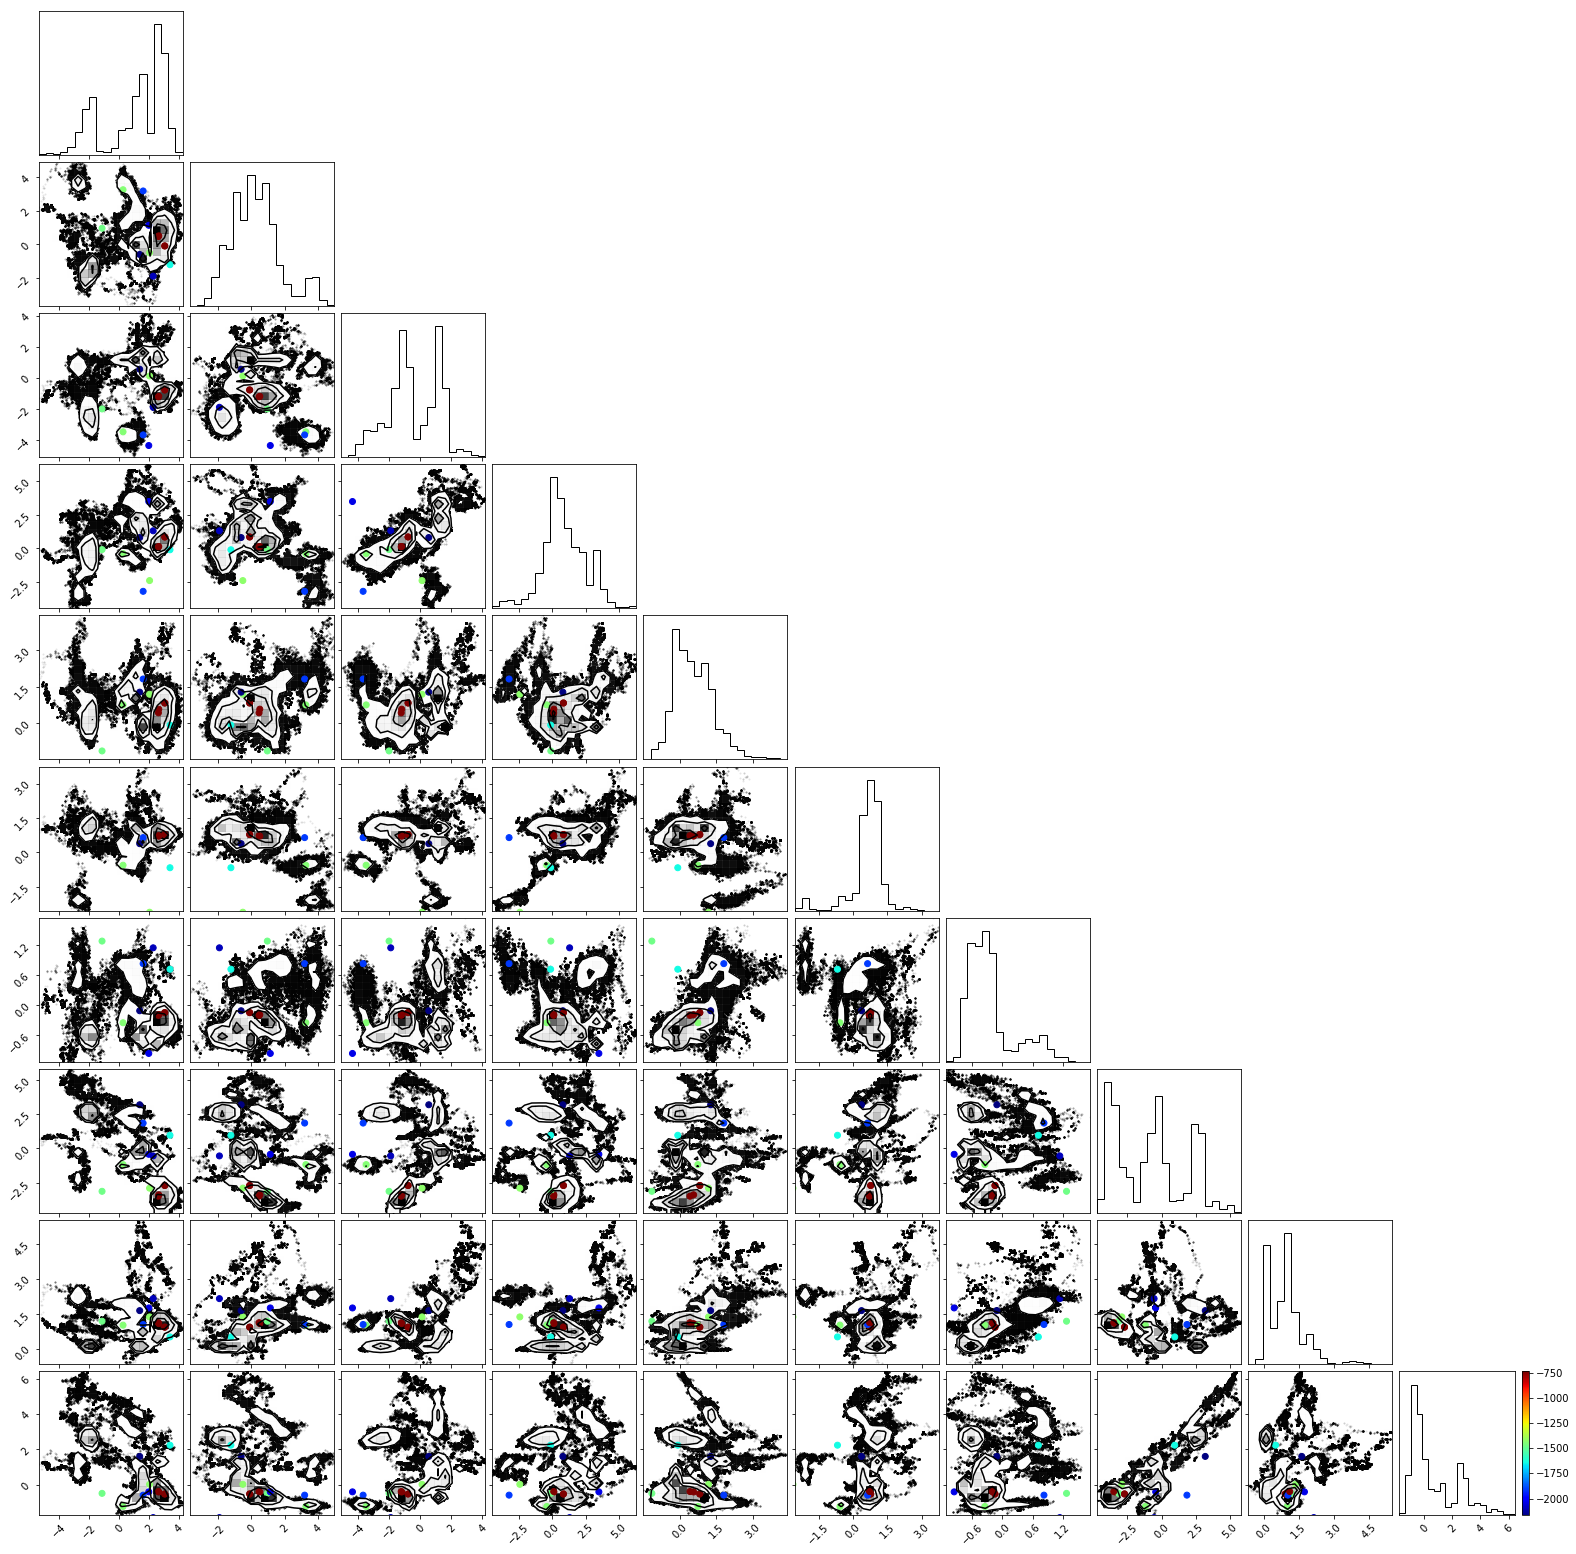

In [123]:
figure = corner.corner(np.reshape(samples_mcmc,[-1,hidden_size]))
axes   = np.array(figure.axes).reshape((hidden_size, hidden_size))

# # # # Loop over the histograms
for yi in range(hidden_size):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax_=ax.scatter(map_minima[:,0,0,xi], map_minima[:,0,0,yi], c=-l_minima, cmap='jet')
        #for i, txt in enumerate(l_minima_old):
        #  ax.annotate('%d'%txt, (map_minima_old[i,0,0,xi], map_minima_old[i,0,0,yi]),color='red', fontsize=10)
plt.colorbar(ax_)

In [0]:
#corrupted data
samples_, kernel_results_ = sess.run([hmc_samples, hmc_kernel_results],feed_dict={x_corr: np.expand_dims(masked_data,-1),sigma_corr:sigma_new, nvp_prior:True})

In [96]:
samples_.shape
print(max(kernel_results_.accepted_results.target_log_prob.flatten()),-min(l_minima))

-987.4353 -734.68427


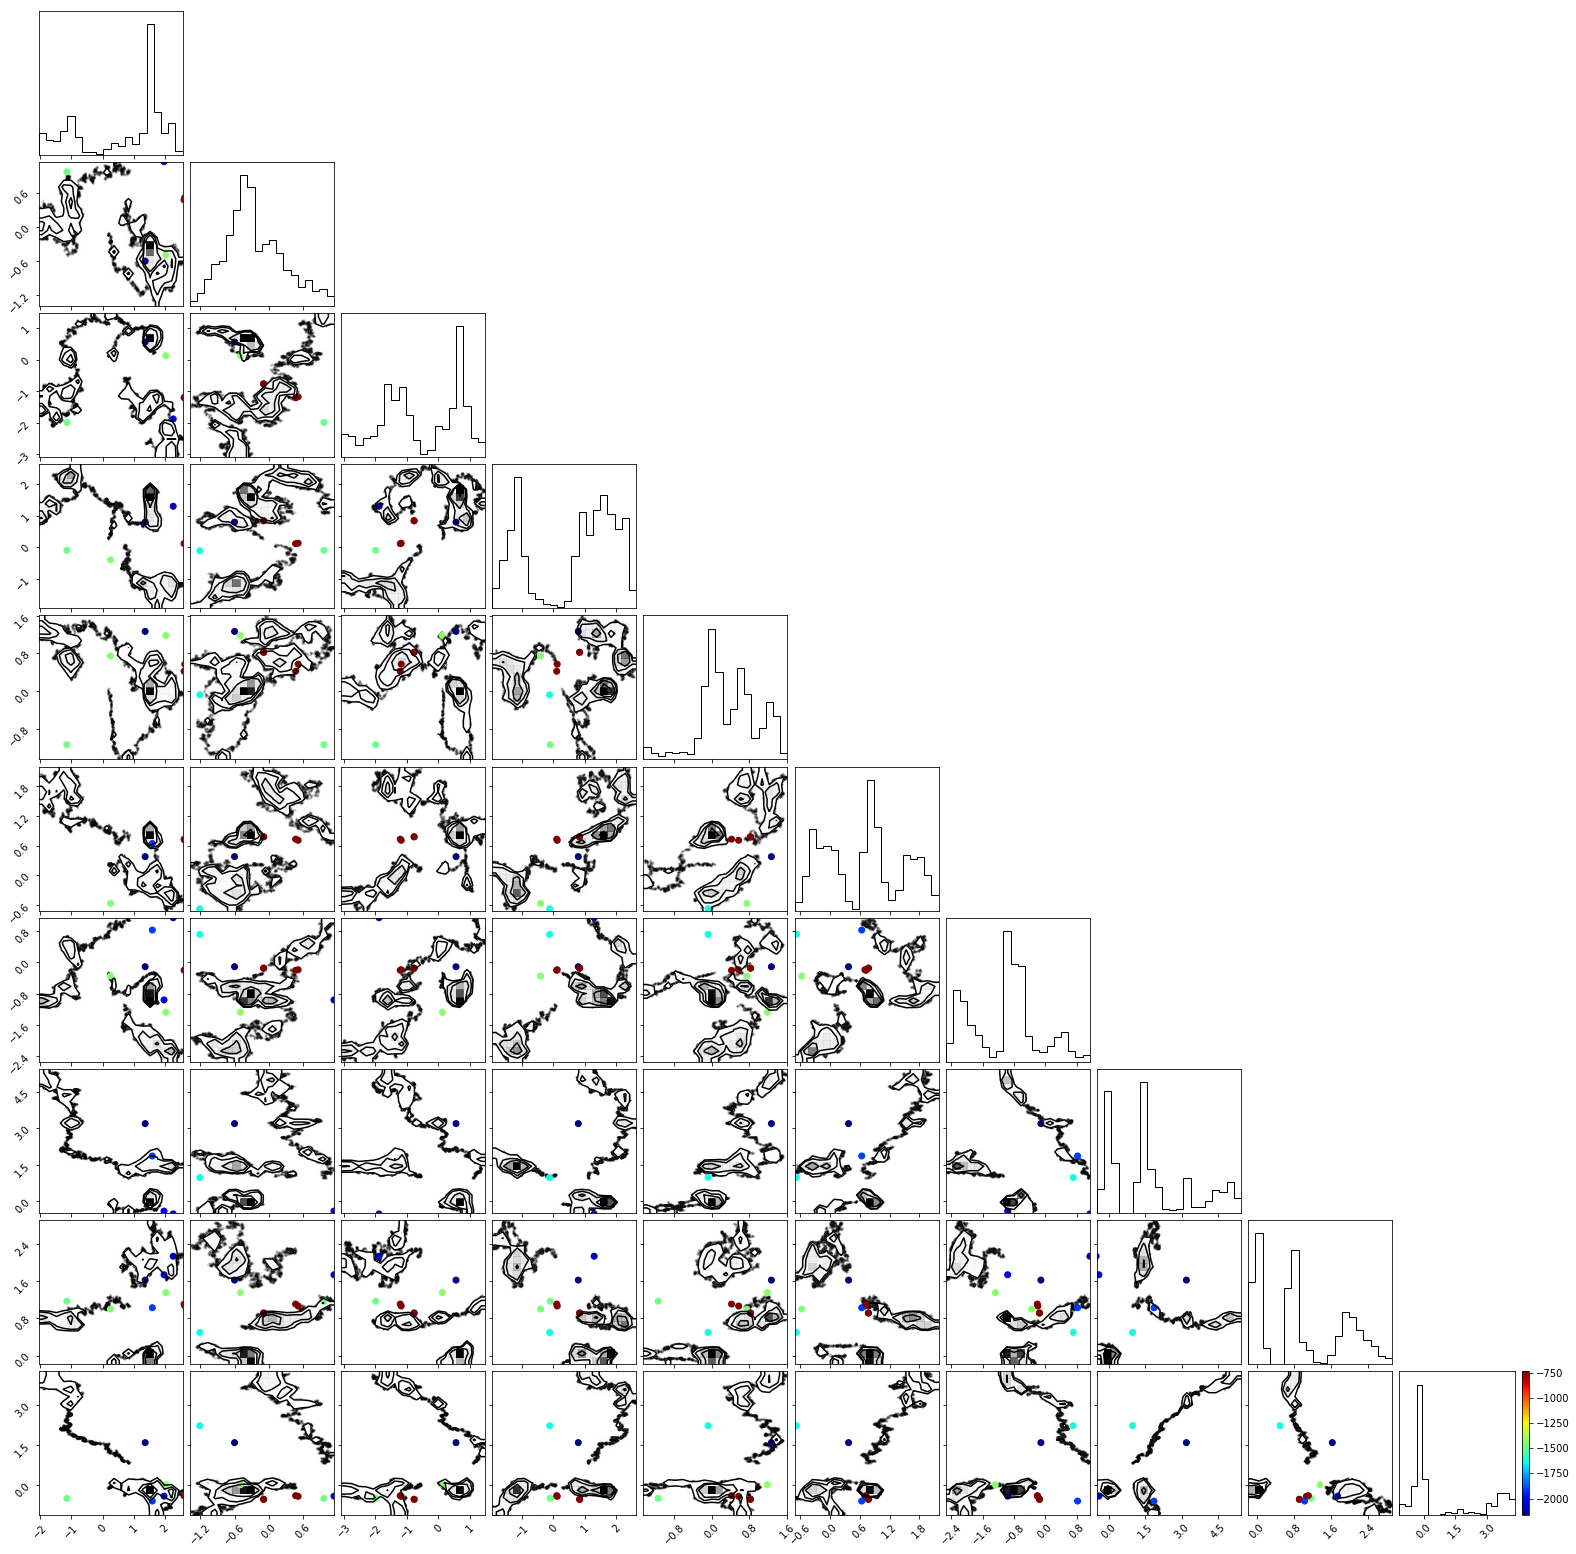

In [111]:
order = np.argsort(l_minima)

figure = corner.corner(np.reshape(samples_,[-1,hidden_size]))#,truths = map_minima_old[order][0,0,0,:])
axes   = np.array(figure.axes).reshape((hidden_size, hidden_size))

# # # # Loop over the histograms
for yi in range(hidden_size):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax_=ax.scatter(map_minima[:,0,0,xi], map_minima[:,0,0,yi], c=-l_minima, cmap='jet')
        #for i, txt in enumerate(l_minima_old):
        #  ax.annotate('%d'%txt, (map_minima_old[i,0,0,xi], map_minima_old[i,0,0,yi]),color='red', fontsize=10)
plt.colorbar(ax_)

mean:0.1693  stddev:0.9419  acceptance:0.6615


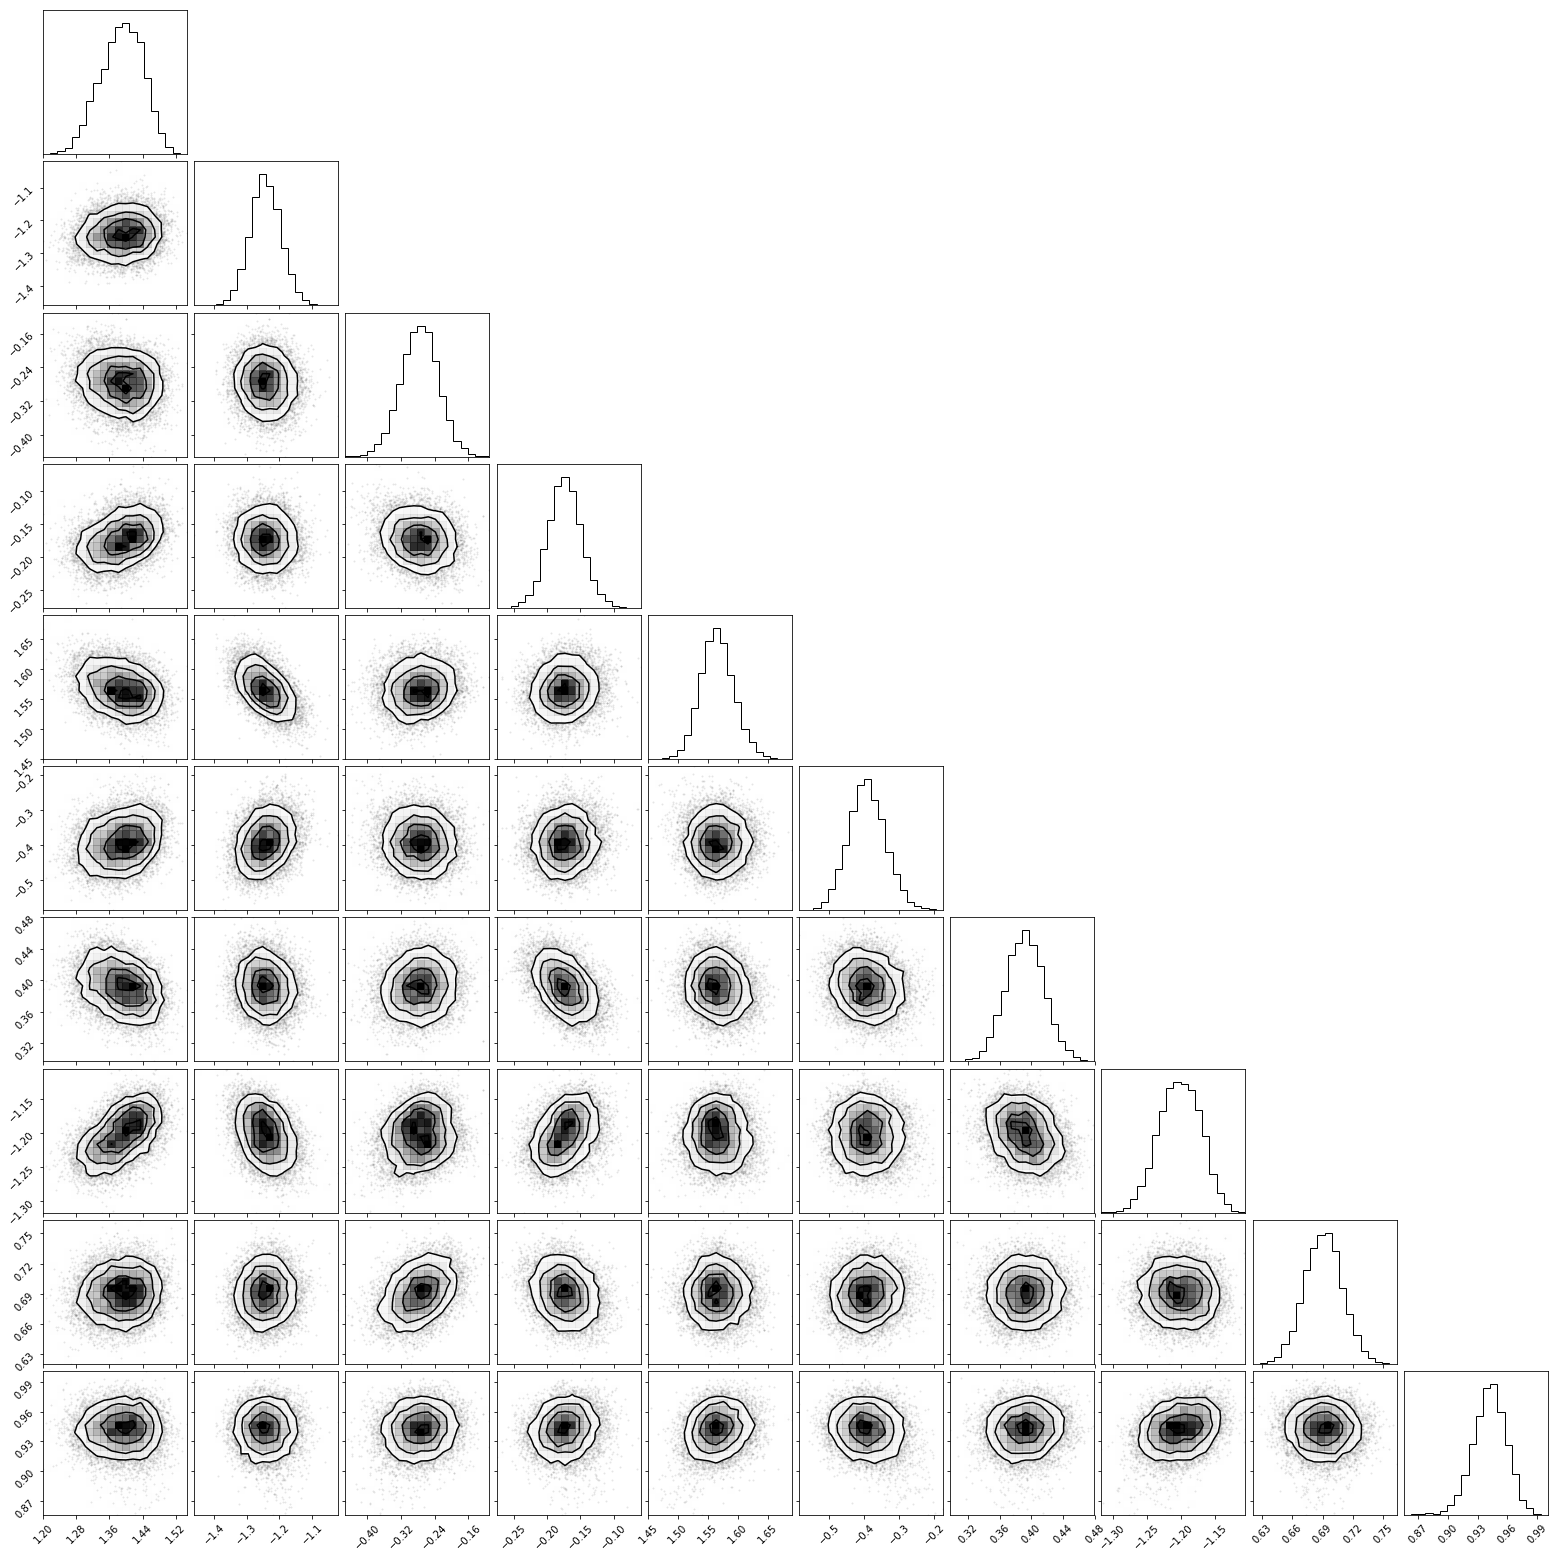

In [16]:
#uncorrupted data
samples_, kernel_results_ = sess.run([samples, kernel_results],feed_dict={x_corr: np.expand_dims(x_true,-1)})
_ = corner.corner(samples_[:,0,:])

**get covariances around minima**

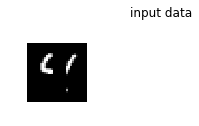

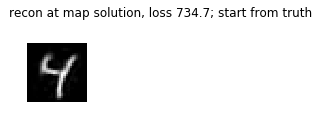

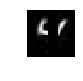

eigenvalues before and after inverse, approx hessian
[array([[9.9702835e-01, 9.9925119e-01, 9.9958295e-01, 9.9990702e-01,
        1.0000029e+00, 1.0000519e+00, 1.0002549e+00, 1.0011321e+00,
        1.0168524e+00, 3.5009253e+05]], dtype=float32), array([[2.85638764e-06, 9.96612446e-01, 9.99115150e-01, 9.99555461e-01,
        9.99985783e-01, 1.00002765e+00, 1.00003685e+00, 1.00022311e+00,
        1.00094479e+00, 1.00157699e+00]])]


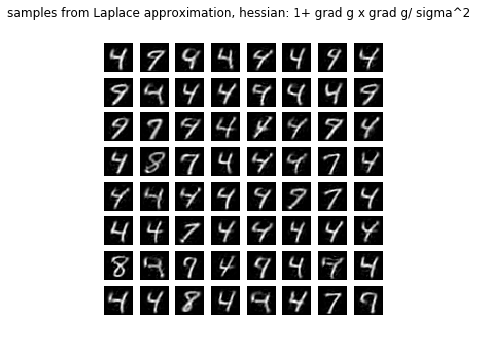

covariances
(1, 10, 10)


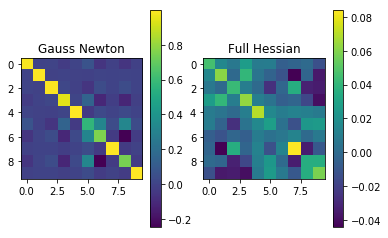

hessians
(1, 10, 10)


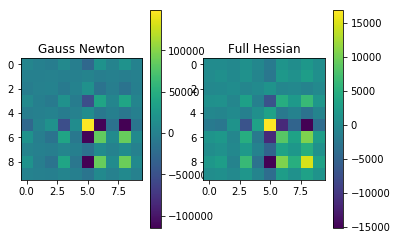

eigenvalues before and after inverse, full hessian
[array([[5.72090864e+00, 6.61040115e+00, 1.08764925e+01, 2.33098011e+01,
        3.70622025e+01, 2.26498688e+02, 5.36290833e+02, 7.73417236e+02,
        1.15284766e+03, 4.54100781e+04]], dtype=float32), array([[2.20215429e-05, 8.67416989e-04, 1.29296344e-03, 1.86466076e-03,
        4.41504452e-03, 2.69815452e-02, 4.28992174e-02, 9.19523624e-02,
        1.51281421e-01, 1.74833587e-01]])]
1


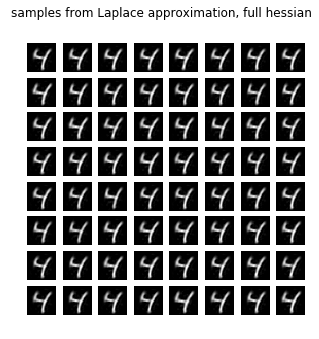

diagonal approx


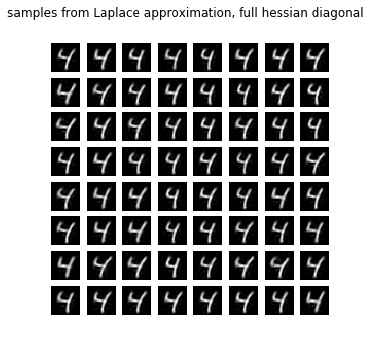

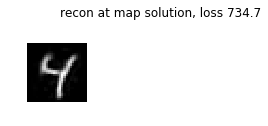

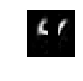

eigenvalues before and after inverse, approx hessian
[array([[9.9727333e-01, 9.9913013e-01, 9.9993467e-01, 1.0000000e+00,
        1.0000134e+00, 1.0001684e+00, 1.0002905e+00, 1.0016388e+00,
        1.0213866e+00, 2.9587528e+05]], dtype=float32), array([[3.37980243e-06, 9.97956800e-01, 9.99583392e-01, 9.99840375e-01,
        9.99992342e-01, 1.00000020e+00, 1.00006666e+00, 1.00009330e+00,
        1.00056753e+00, 1.00312756e+00]])]


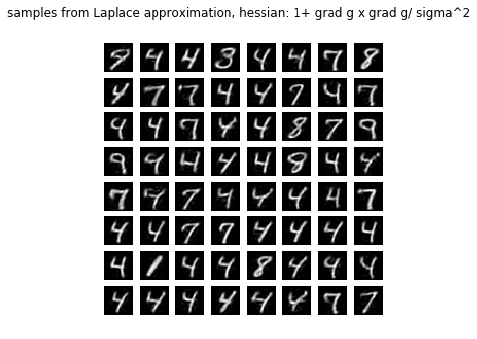

covariances
(1, 10, 10)


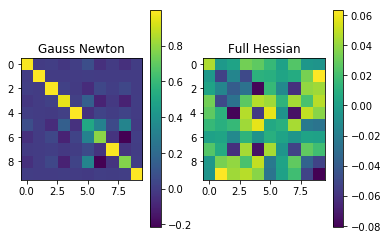

hessians
(1, 10, 10)


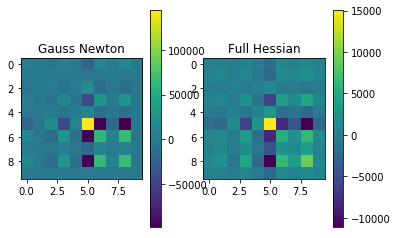

eigenvalues before and after inverse, full hessian
[array([[-6.0655465e+00, -3.5481119e+00,  6.8533335e+00,  2.9616970e+01,
         4.1541489e+01,  2.3303680e+02,  5.3660559e+02,  8.5657581e+02,
         1.2059550e+03,  3.3293609e+04]], dtype=float32), array([[-2.81927918e-01, -1.64872550e-01,  3.00358000e-05,
         8.29216648e-04,  1.16743762e-03,  1.86356666e-03,
         4.29116705e-03,  2.40723219e-02,  3.37641912e-02,
         1.45919613e-01]])]
1
full hessian fails


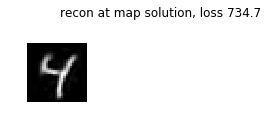

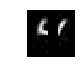

eigenvalues before and after inverse, approx hessian
[array([[9.8610508e-01, 9.9851555e-01, 9.9980915e-01, 9.9999559e-01,
        1.0000008e+00, 1.0000280e+00, 1.0001128e+00, 1.0005336e+00,
        1.0035385e+00, 3.0087503e+05]], dtype=float32), array([[3.32363942e-06, 9.95086423e-01, 9.99378628e-01, 9.99910473e-01,
        9.99953735e-01, 9.99999902e-01, 1.00000614e+00, 1.00013902e+00,
        1.00052657e+00, 1.00272649e+00]])]


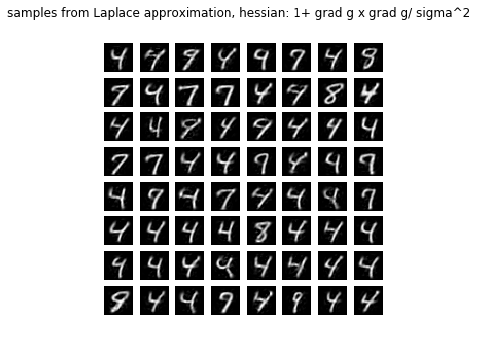

covariances
(1, 10, 10)


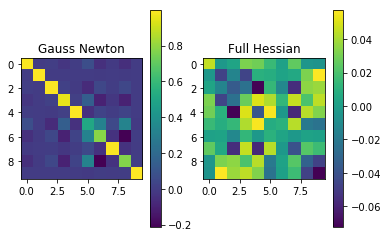

hessians
(1, 10, 10)


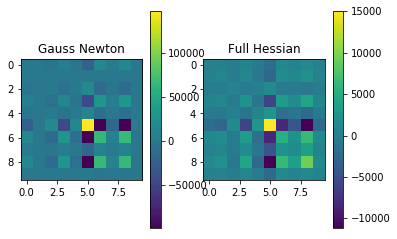

eigenvalues before and after inverse, full hessian
[array([[-6.6991410e+00, -4.0497985e+00,  6.6128054e+00,  2.9823301e+01,
         4.1938690e+01,  2.4145488e+02,  5.2824878e+02,  8.7758185e+02,
         1.1919084e+03,  3.3436199e+04]], dtype=float32), array([[-2.46919492e-01, -1.49278140e-01,  2.99077081e-05,
         8.38991607e-04,  1.13949176e-03,  1.89304734e-03,
         4.14156247e-03,  2.38441731e-02,  3.35306521e-02,
         1.51208504e-01]])]
1
full hessian fails


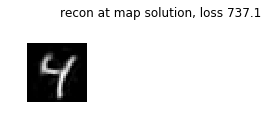

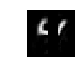

eigenvalues before and after inverse, approx hessian
[array([[9.9112093e-01, 9.9883544e-01, 9.9978447e-01, 9.9998069e-01,
        9.9999917e-01, 1.0000161e+00, 1.0003054e+00, 1.0005622e+00,
        1.0009078e+00, 3.1720112e+05]], dtype=float32), array([[3.15257384e-06, 9.99224585e-01, 9.99453582e-01, 9.99733148e-01,
        9.99988780e-01, 1.00000039e+00, 1.00000472e+00, 1.00016375e+00,
        1.00116436e+00, 1.00276216e+00]])]


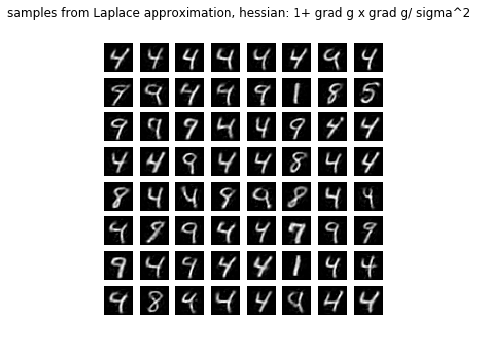

covariances
(1, 10, 10)


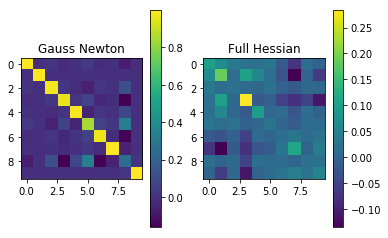

hessians
(1, 10, 10)


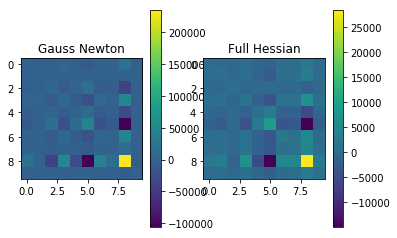

eigenvalues before and after inverse, full hessian
[array([[2.0255513e+00, 4.1770473e+00, 1.0122445e+01, 1.7137529e+01,
        4.3977760e+01, 2.0337839e+02, 3.5745068e+02, 1.2896115e+03,
        1.9658933e+03, 4.2403918e+04]], dtype=float32), array([[2.35827204e-05, 5.08675110e-04, 7.75427338e-04, 2.79758677e-03,
        4.91694185e-03, 2.27387425e-02, 5.83484039e-02, 9.87959375e-02,
        2.39427801e-01, 4.93300526e-01]])]
1


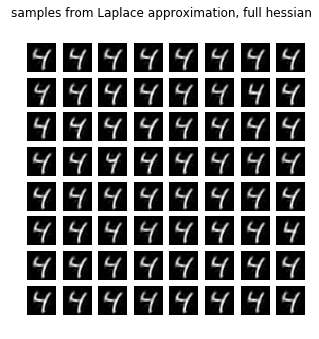

diagonal approx


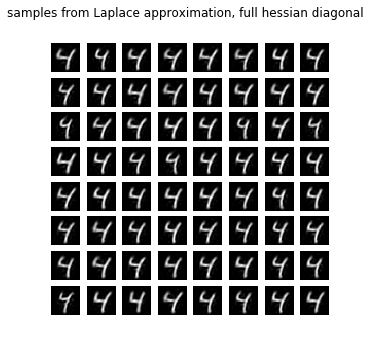

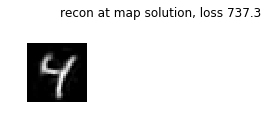

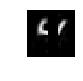

eigenvalues before and after inverse, approx hessian
[array([[9.9929029e-01, 9.9976045e-01, 9.9987835e-01, 9.9994183e-01,
        1.0000316e+00, 1.0001698e+00, 1.0003175e+00, 1.0003806e+00,
        1.0043864e+00, 1.7957178e+05]], dtype=float32), array([[5.56880569e-06, 9.98517805e-01, 9.99617795e-01, 9.99799691e-01,
        9.99989251e-01, 1.00000792e+00, 1.00005111e+00, 1.00015989e+00,
        1.00029381e+00, 1.00107724e+00]])]


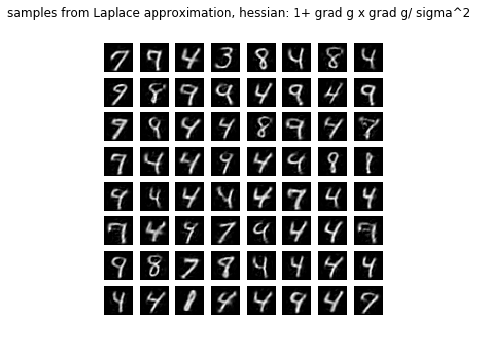

covariances
(1, 10, 10)


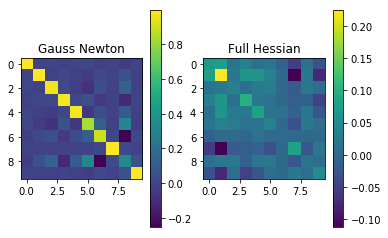

hessians
(1, 10, 10)


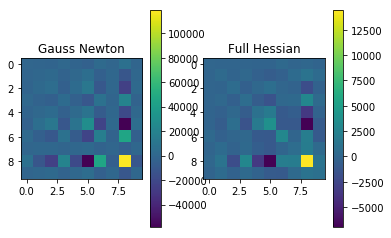

eigenvalues before and after inverse, full hessian
[array([[2.5133166e+00, 9.0638027e+00, 1.0746515e+01, 1.4344312e+01,
        3.2970669e+01, 2.1862549e+02, 3.7046869e+02, 8.8929492e+02,
        3.4610217e+03, 2.0449496e+04]], dtype=float32), array([[4.89009669e-05, 2.88932040e-04, 1.12448605e-03, 2.69928360e-03,
        4.57402553e-03, 3.03299311e-02, 6.97143174e-02, 9.30553583e-02,
        1.10318969e-01, 3.97858265e-01]])]
1


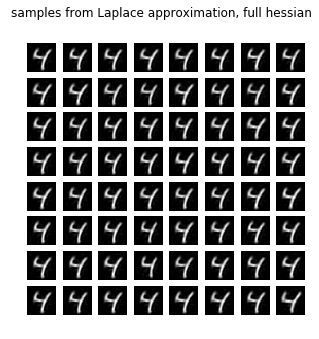

diagonal approx


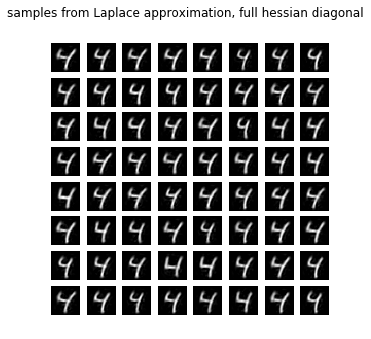

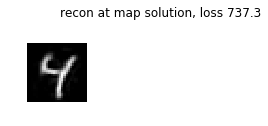

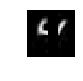

eigenvalues before and after inverse, approx hessian
[array([[9.9498695e-01, 9.9901551e-01, 9.9986625e-01, 9.9995840e-01,
        9.9998730e-01, 1.0000324e+00, 1.0001401e+00, 1.0006797e+00,
        1.0009750e+00, 1.7944130e+05]], dtype=float32), array([[5.57285094e-06, 9.98262352e-01, 9.99129685e-01, 9.99715014e-01,
        9.99942062e-01, 9.99978375e-01, 1.00000611e+00, 1.00001864e+00,
        1.00010468e+00, 1.00072246e+00]])]


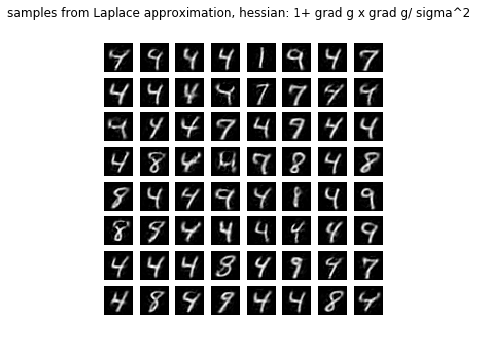

covariances
(1, 10, 10)


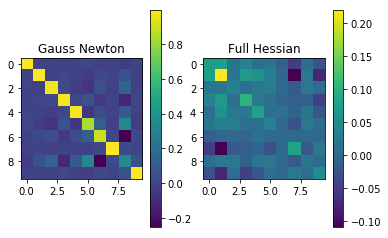

hessians
(1, 10, 10)


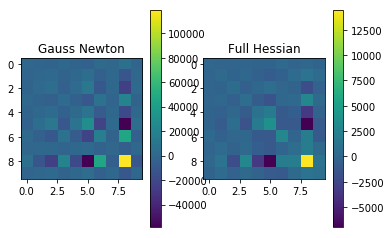

eigenvalues before and after inverse, full hessian
[array([[2.57247281e+00, 9.18569088e+00, 1.08598585e+01, 1.43049173e+01,
        3.29232407e+01, 2.18594742e+02, 3.71096985e+02, 8.89323181e+02,
        3.46116846e+03, 2.04343086e+04]], dtype=float32), array([[4.89372942e-05, 2.88919876e-04, 1.12445117e-03, 2.69471306e-03,
        4.57467112e-03, 3.03736311e-02, 6.99063112e-02, 9.20886349e-02,
        1.08873279e-01, 3.88702218e-01]])]
1


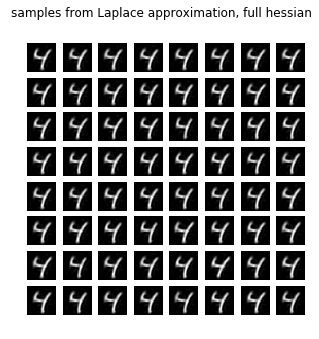

diagonal approx


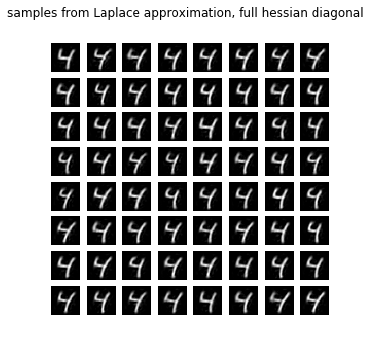

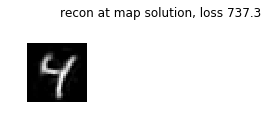

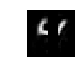

eigenvalues before and after inverse, approx hessian
[array([[9.9950671e-01, 9.9970502e-01, 9.9995589e-01, 9.9997979e-01,
        1.0000030e+00, 1.0000644e+00, 1.0001798e+00, 1.0008316e+00,
        1.0068265e+00, 1.6433841e+05]], dtype=float32), array([[6.08500702e-06, 9.98896424e-01, 9.99463599e-01, 9.99845936e-01,
        9.99864876e-01, 9.99972755e-01, 9.99984437e-01, 1.00002763e+00,
        1.00006302e+00, 1.00123595e+00]])]


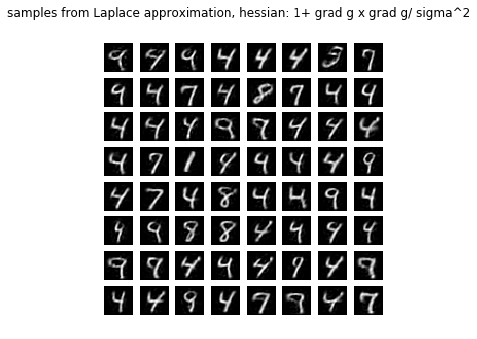

covariances
(1, 10, 10)


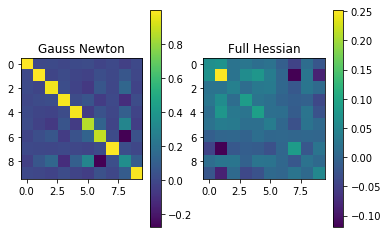

hessians
(1, 10, 10)


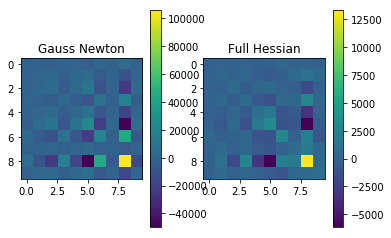

eigenvalues before and after inverse, full hessian
[array([[2.3914242e+00, 9.4307518e+00, 1.0271195e+01, 1.3926537e+01,
        3.2222569e+01, 2.0896312e+02, 3.7882269e+02, 9.2789844e+02,
        3.4685593e+03, 1.8736744e+04]], dtype=float32), array([[5.33710705e-05, 2.88304151e-04, 1.07770396e-03, 2.63975557e-03,
        4.78553275e-03, 3.10342567e-02, 7.18068019e-02, 9.73615062e-02,
        1.06026337e-01, 4.18133876e-01]])]
1


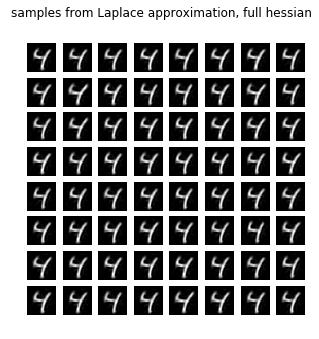

diagonal approx


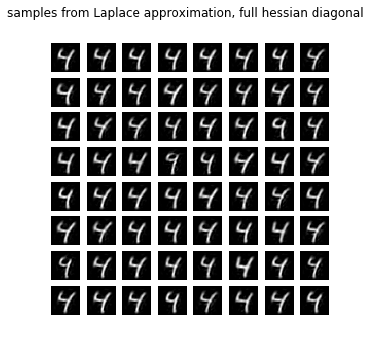

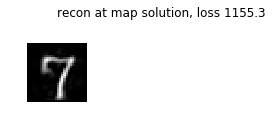

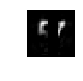

eigenvalues before and after inverse, approx hessian
[array([[9.9892735e-01, 9.9976808e-01, 9.9986798e-01, 9.9996221e-01,
        9.9999881e-01, 1.0000046e+00, 1.0002052e+00, 1.0005280e+00,
        1.0068625e+00, 6.8472352e+04]], dtype=float32), array([[1.46044415e-05, 9.99407936e-01, 9.99761456e-01, 9.99928560e-01,
        9.99999908e-01, 1.00000437e+00, 1.00002083e+00, 1.00009251e+00,
        1.00013265e+00, 1.00043335e+00]])]


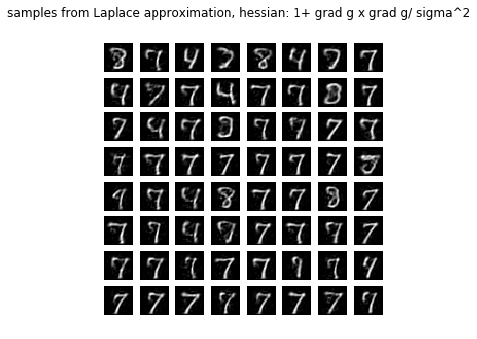

covariances
(1, 10, 10)


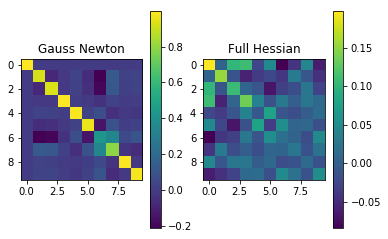

hessians
(1, 10, 10)


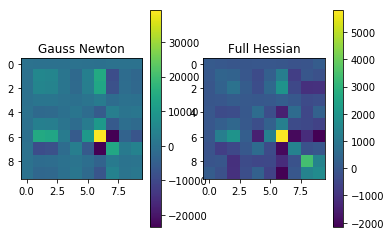

eigenvalues before and after inverse, full hessian
[array([[-5.7214622e+00,  2.7288551e+00,  4.0221620e+00,  8.2763519e+00,
         1.1445648e+01,  6.0387119e+01,  1.5481580e+02,  1.1249674e+03,
         3.9262449e+03,  9.3544570e+03]], dtype=float32), array([[-1.74781817e-01,  1.06900897e-04,  2.54696348e-04,
         8.88914468e-04,  6.45929354e-03,  1.65598995e-02,
         8.73705349e-02,  1.20826937e-01,  2.48627461e-01,
         3.66443022e-01]])]
1
full hessian fails


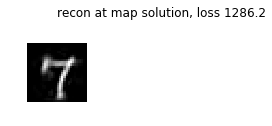

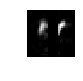

eigenvalues before and after inverse, approx hessian
[array([[9.9832422e-01, 9.9973935e-01, 9.9986857e-01, 9.9995303e-01,
        9.9999887e-01, 1.0000188e+00, 1.0000385e+00, 1.0000956e+00,
        1.0018722e+00, 2.3604891e+04]], dtype=float32), array([[4.23641080e-05, 9.99751643e-01, 9.99935648e-01, 9.99984312e-01,
        1.00000183e+00, 1.00001166e+00, 1.00002362e+00, 1.00004114e+00,
        1.00014326e+00, 1.00017225e+00]])]


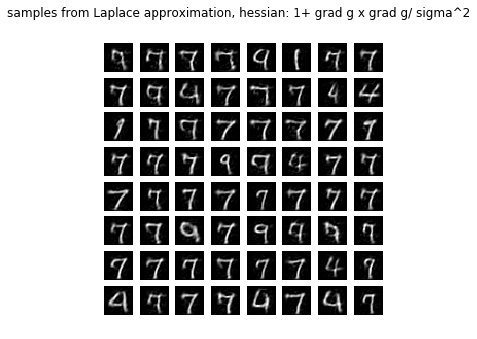

covariances
(1, 10, 10)


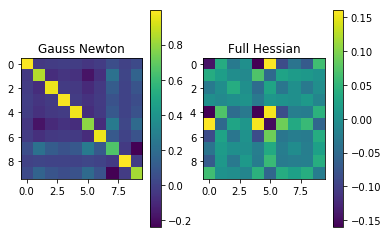

hessians
(1, 10, 10)


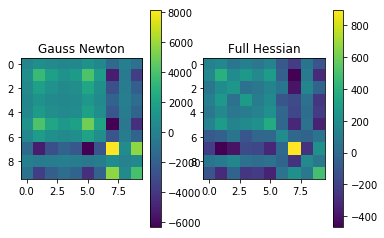

eigenvalues before and after inverse, full hessian
[array([[-1.40784750e+01, -1.70705903e+00,  1.19090185e+01,
         1.97615414e+01,  4.38218613e+01,  1.10703331e+02,
         1.19644554e+02,  3.00523438e+02,  7.36775635e+02,
         1.98908130e+03]], dtype=float32), array([[-5.85781375e-01, -7.10294625e-02,  5.02744489e-04,
         1.35726574e-03,  3.32752823e-03,  8.35808460e-03,
         9.03315613e-03,  2.28197153e-02,  5.06033532e-02,
         8.39700677e-02]])]
1
full hessian fails


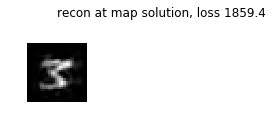

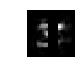

eigenvalues before and after inverse, approx hessian
[array([[9.9809462e-01, 9.9985439e-01, 9.9996942e-01, 9.9999952e-01,
        1.0000157e+00, 1.0000206e+00, 1.0000645e+00, 1.0006912e+00,
        1.0078036e+00, 9.0674617e+04]], dtype=float32), array([[1.10284396e-05, 9.98036865e-01, 9.99233714e-01, 9.99761913e-01,
        9.99983201e-01, 9.99999927e-01, 1.00000914e+00, 1.00001758e+00,
        1.00008700e+00, 1.00080465e+00]])]


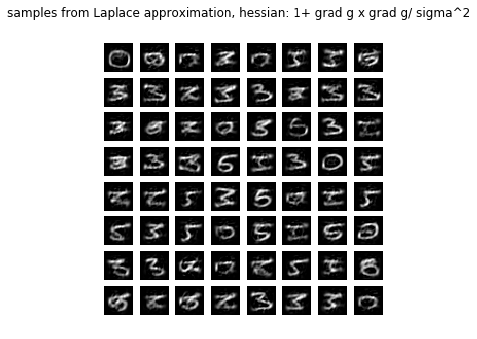

covariances
(1, 10, 10)


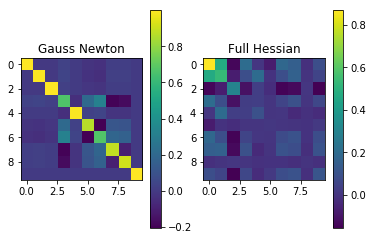

hessians
(1, 10, 10)


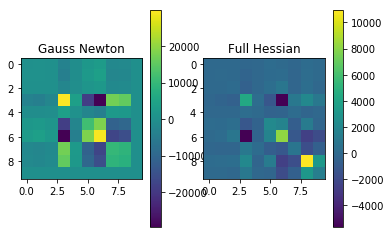

eigenvalues before and after inverse, full hessian
[array([[-8.2195330e+00,  7.1022034e-01,  2.1201355e+00,  3.3149121e+00,
         1.7623253e+01,  5.0969902e+01,  8.1037054e+02,  1.4691553e+03,
         9.9847441e+03,  1.5958606e+04]], dtype=float32), array([[-1.21655139e-01,  6.26621024e-05,  1.00152838e-04,
         6.80663250e-04,  1.23400227e-03,  1.96196535e-02,
         5.67420658e-02,  3.01661150e-01,  4.71601485e-01,
         1.40775673e+00]])]
1
full hessian fails


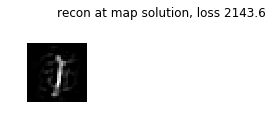

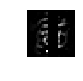

eigenvalues before and after inverse, approx hessian
[array([[9.9989092e-01, 9.9999046e-01, 9.9999589e-01, 9.9999881e-01,
        1.0000002e+00, 1.0000004e+00, 1.0000014e+00, 1.0000097e+00,
        1.0000418e+00, 3.2518103e+03]], dtype=float32), array([[3.07521006e-04, 9.99981201e-01, 9.99997355e-01, 9.99999100e-01,
        9.99999707e-01, 9.99999958e-01, 1.00000007e+00, 1.00000070e+00,
        1.00000469e+00, 1.00002474e+00]])]


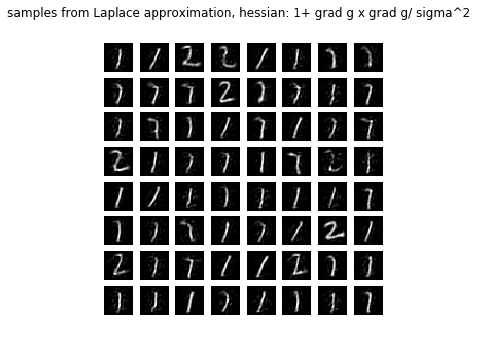

covariances
(1, 10, 10)


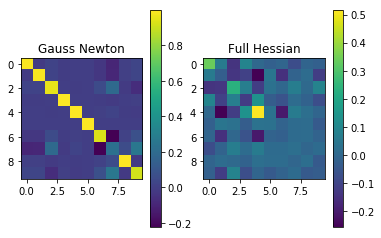

hessians
(1, 10, 10)


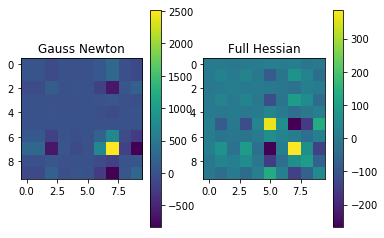

eigenvalues before and after inverse, full hessian
[array([[-28.946198 ,  -4.1321096,  -2.6032844,   1.4318804,   1.9299233,
          4.2140207,   8.846627 ,  19.484993 , 181.83423  , 797.1283   ]],
      dtype=float32), array([[-0.38413175, -0.24200712, -0.03454678,  0.0012545 ,  0.00549952,
         0.05132159,  0.1130375 ,  0.23730277,  0.51815386,  0.69838381]])]
1
full hessian fails


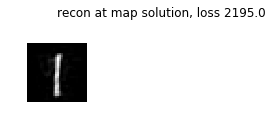

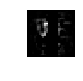

eigenvalues before and after inverse, approx hessian
[array([[9.9999440e-01, 9.9999791e-01, 9.9999964e-01, 9.9999988e-01,
        1.0000005e+00, 1.0000011e+00, 1.0000012e+00, 1.0000305e+00,
        1.0000523e+00, 1.3078947e+03]], dtype=float32), array([[7.64587718e-04, 9.99979064e-01, 9.99993969e-01, 9.99998724e-01,
        9.99999241e-01, 9.99999884e-01, 1.00000002e+00, 1.00000015e+00,
        1.00000068e+00, 1.00001389e+00]])]


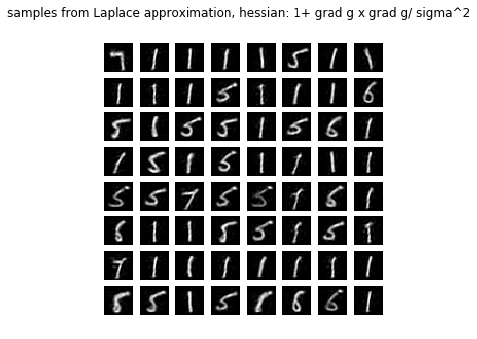

covariances
(1, 10, 10)


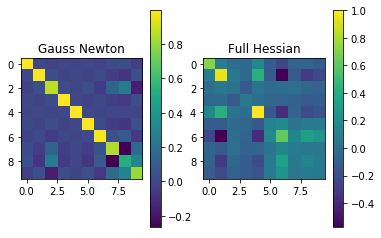

hessians
(1, 10, 10)


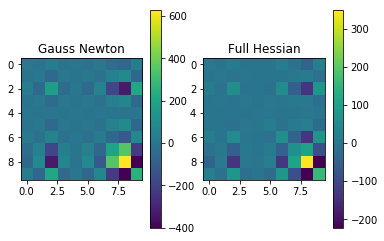

eigenvalues before and after inverse, full hessian
[array([[-4.2318578e+00,  4.7062469e-01,  1.4444933e+00,  1.5855831e+00,
         3.1589882e+00,  9.0706186e+00,  1.5960087e+01,  2.0067579e+01,
         3.8227142e+01,  6.4044653e+02]], dtype=float32), array([[-2.36302300e-01,  1.56141048e-03,  2.61594266e-02,
         4.98316233e-02,  6.26562570e-02,  1.10246174e-01,
         3.16555742e-01,  6.30681367e-01,  6.92284642e-01,
         2.12479839e+00]])]
1
full hessian fails


In [64]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis = [] 
# order minima by loss function value
l_minima   = np.asarray(l_minima)
map_minima = np.asarray(map_minima)
order      = np.argsort(l_minima)


# go through minima
for ii,ini_ in enumerate(map_minima[order]):
  
  
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:False})
  

  figure(figsize=(5,5))
  if ii==0:
    suptitle('recon at map solution, loss %.1f; start from truth'%l_minima[ii])
  else:
    suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()

  # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})]
  
  print('eigenvalues before and after inverse, approx hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False}))

  # get samples 
  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace approximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  
  
  ## plot sigma
  print('covariances')
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  print('hessians')
  sigma_m = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True}))
  try:
    for s in [1]:
      print(s)
   
      _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      figure(figsize=(5,5))
      suptitle('samples from Laplace approximation, full hessian')
      for i in range(sample_size_z):
          subplot(8,8,i+1)
          imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
          axis('off')
      plt.show()
      
    print('diagonal approx')
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:1, diag_hess:True})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, diag_hess:True})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian diagonal')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
  
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')


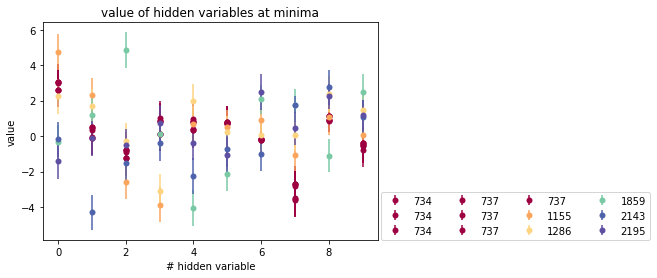

In [65]:
# check if minima are distinct
order = np.argsort(l_minima)
map_minima = np.asarray(map_minima[order])
l_minima   = np.asarray(l_minima[order])
varis      = np.asarray(varis)

colors = matplotlib.colors.Normalize(vmin=min(l_minima), vmax=max(l_minima))
cmap = matplotlib.cm.get_cmap('Spectral')

plt.title('value of hidden variables at minima')
for ii in range(len(map_minima)):
  yerr_= np.sqrt(varis[ii,0])

  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima[ii]), marker='o',ls='', c=cmap(colors(l_minima[ii])), mew=0, yerr=yerr_, label ='%d'%l_minima[ii])
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.savefig(plot_path+'minima_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

**explore posterior around minima**

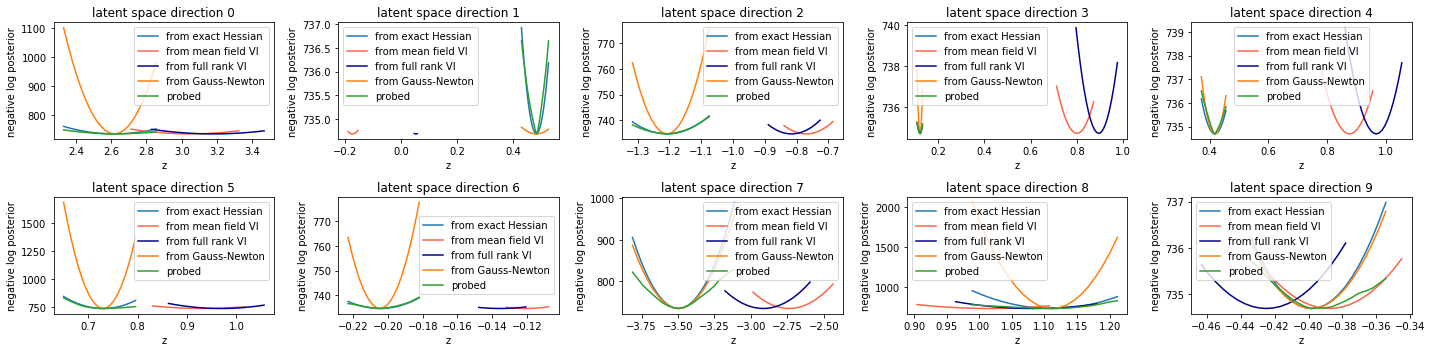

In [67]:
order     = np.argsort(l_minima)[0]

# testing Hessian
for ii,ini_ in enumerate([map_minima[order]]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B    = measured_hessian[0,nn,nn]
    GN   = GN_hessian[0,nn,nn]
    VIm  = np.linalg.inv(VI_cov)[0,nn,nn]

    z_VI = (0.01*(np.arange(21)-11))*VI_mean[0,nn]
    
    VImf  = np.linalg.inv(VI_f_cov)[0,nn,nn]

    z_VIf = (0.01*(np.arange(21)-11))*VI_f_mean[0,nn]

    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(21):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.01*(jj-11))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      losses.append(-ll)
    

    
    
    plt.plot(ini_[0][:,nn]+(0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+B*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from exact Hessian')
    plt.plot(z_VI+VI_mean[0,nn],-ll0+VIm*z_VI**2,label='from mean field VI', color='tomato')
    plt.plot(z_VIf+VI_f_mean[0,nn],-ll0+VImf*z_VIf**2,label='from full rank VI', color='darkblue')
    plt.plot(ini_[0][:,nn]+(0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+GN*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.plot(ini_[0][:,nn]+(0.01*(np.arange(21)-11))*ini_[0][:,nn],losses,label='probed')
    plt.legend()
    plt.xlabel('z')
    plt.ylabel('negative log posterior')
    plt.tight_layout()
    plt.savefig(plot_path+'probing_posterior_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')


**Build Gaussian Mixture Model**

In [69]:
mu_     =[]
sigma_  =[]
w_tilde =[]
#diag    =[]

order   = np.argsort(l_minima)
mus     = [map_minima[order[0]]]
# loop over components, start with lowest, go higher and higher
for ii in range(num_comp):
  
  # do Laplace approximation around this minimum
  print(sess.run(MAP_reset,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]}))
  mu_+=[sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})]
  sigma_+=[sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})]
  

  #diag+=[sess.run(lapl_variance_MAP,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
  logdet_ = sess.run(log_det,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})
  logprob = sess.run(posterior_MAP,feed_dict={x_corr: data, sigma_corr:sigma_new})
  print(logdet_,logprob,0.5*logdet_+logprob)
  w_tilde+=[np.exp(0.5*(logdet_+logprob))]

mu_    = np.asarray(mu_)
sigma_ = np.asarray(sigma_)

w_tilde= np.asarray(w_tilde)
print(w_tilde)

A = 1./np.sum(w_tilde)

w = w_tilde*A
w = np.squeeze(w)
print(w)
w=[w]

_=sess.run(update_a,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_b,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_c,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })



[[ 2.6190708   0.48442397 -1.2076888   0.12193786  0.4180391   0.72992724
  -0.20453341 -3.4972818   1.1117862  -0.39823318]]
[-48.9122347] [-734.68805] [-759.14416667]
[[6.97204718e-171]]
1.0


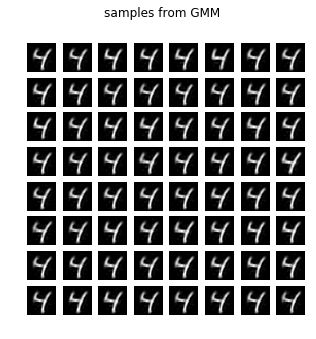

In [70]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={x_corr: data, sigma_corr:sigma_new})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

**minima without nvp**

0
3890.3364
1959.1981
1959.5992
1959.0587
1958.3679
1958.3707
1958.4031
1958.424
1958.5094
1958.3202
1
2347.845
714.1892
715.21533
714.8303
713.9297
713.984
714.03064
713.88574
713.98016
713.7779
2
2684.6426
720.0725
720.7534
720.01984
719.5433
719.5436
719.5537
719.5471
719.5503
719.543
3
2544.466
715.8527
716.9342
714.77466
713.877
713.97455
713.9258
713.84827
713.9603
713.7777
4
2498.1372
1425.5186
1425.5586
1425.1626
1424.1106
1424.0955
1424.1638
1424.2406
1424.1365
1424.0698
5
1495.8269
721.3124
721.76624
721.59576
721.20325
721.2087
721.22675
721.1926
721.2185
721.17834
6
2995.2068
715.0438
714.2657
714.765
713.94763
713.83673
713.8225
714.0238
713.9539
713.7776
7
2245.8762
723.0961
722.8054
722.80585
722.4314
722.4642
722.47125
722.4327
722.4555
722.40546
8
2918.7454
1366.9164
1369.682
1365.2465
1364.7677
1364.7737
1364.6284
1364.7498
1364.9977
1364.4554
9
3899.258
720.5413
721.1754
720.9077
719.544
719.5429
719.5466
719.54803
719.55084
719.5427


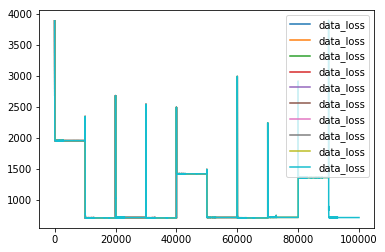

In [38]:
l_minima_old=[]
map_minima_old=[]
posterior_loss3=[]
for ii in range(10):
  print(ii)
  ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, nvp_prior: False, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(3000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  for ii in range(5000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-4
  for ii in range(2000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  l_minima_old+=[ll]
  map_minima_old+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior: False, lr:lrate})]
  plot(posterior_loss3,label='data_loss')
  legend()

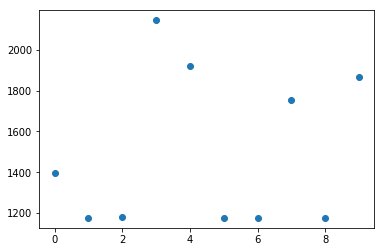

In [23]:
plt.figure()
plt.plot(np.arange(10),l_minima_old,ls='',marker='o')
plt.show()

In [125]:
import pickle
try:
  l_minima_old,map_minima_old = pickle.load(open(minima_path+'nvp_minima_nonnvp_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([l_minima_old,map_minima_old],open(minima_path+'nvp_minima_nonnvp_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))
  
map_minima_old = np.asarray(map_minima_old)
l_minima_old  = np.asarray(l_minima_old)

print(map_minima_old)

[[[[-0.7923539   1.5970947   1.5343508   0.04641243 -0.780231
    -0.6863949   1.1647897   0.31511375  1.1303812   0.3975146 ]]]


 [[[ 1.4395659  -0.05169467 -0.9570933  -0.22535267  1.7277365
    -0.51103675  0.05222924 -1.4663507   0.565135    1.2672961 ]]]


 [[[ 1.3863779  -0.46198204 -0.8511998  -0.25305322  1.686109
    -0.34971595  0.01644781 -1.5385765   0.6641998   0.95052224]]]


 [[[ 1.4395248  -0.0516899  -0.9570636  -0.22538324  1.7277769
    -0.5111041   0.05225403 -1.4663287   0.5651562   1.2672976 ]]]


 [[[ 0.43194094  0.22845057 -1.2477007  -0.35619962  1.5260986
    -0.22716324  1.4763312  -0.74448305  0.99762946 -0.26632553]]]


 [[[ 1.4682012  -0.23448974 -0.55505043 -0.24510293  1.6650419
    -0.37470245  0.17325807 -1.255145    0.59373885  1.3508488 ]]]


 [[[ 1.4396101  -0.05173619 -0.957069   -0.22538015  1.7276957
    -0.51101834  0.05218298 -1.4663926   0.56509984  1.267332  ]]]


 [[[ 1.4241133  -0.3957534  -0.57334936 -0.2593581   1.6363993
    -0.40029195

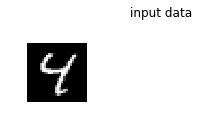

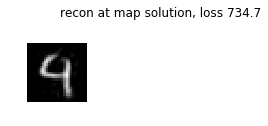

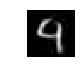

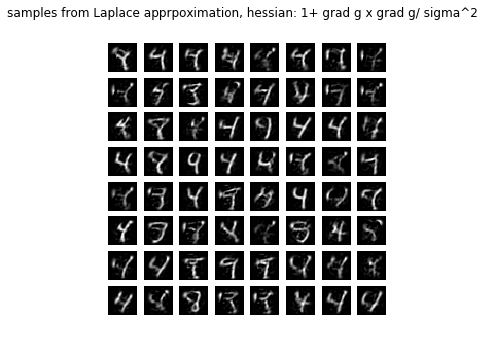

<Figure size 360x360 with 0 Axes>

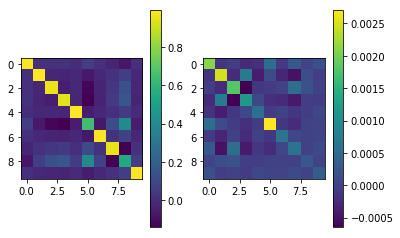

eigenvalues before and after inverse, full hessian
[array([[ 295.56754,  323.79993,  499.59866,  548.0393 , 1303.2059 ,
        1928.2512 , 2408.4624 , 2883.6624 , 4263.6104 , 6316.3467 ]],
      dtype=float32), array([[0.00015832, 0.00023454, 0.00034678, 0.0004152 , 0.0005186 ,
        0.00076734, 0.00182469, 0.00200161, 0.00308833, 0.00338332]])]


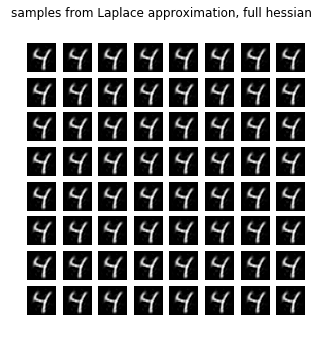

3668.8733
4529.705
3326.061
3351.1743
4875.9985
2776.5168
2532.6074
1941.6797
3053.084
3832.9746
2146.8596
3008.916
3297.4705
2859.096
3381.3179
3247.8804
2240.019
3554.5134
2462.25
3506.1858


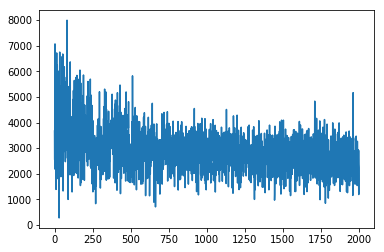

variance of VI [[-1.2170253   1.7620015   0.09897376 -1.8091397  -1.097841   -0.9518143
  -0.98718333 -0.13389398 -2.072787   -1.2791116 ]]


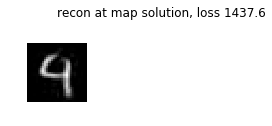

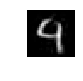

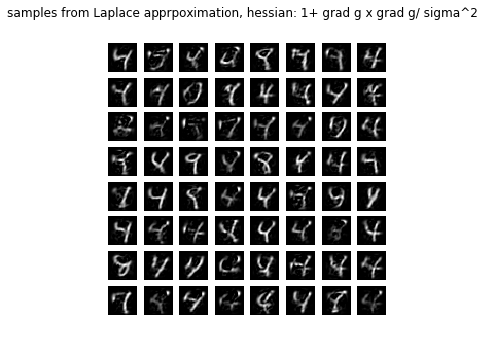

<Figure size 360x360 with 0 Axes>

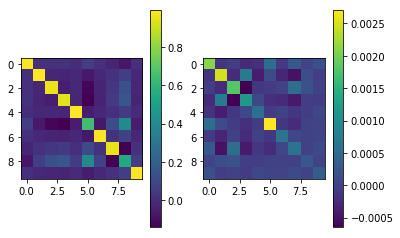

eigenvalues before and after inverse, full hessian
[array([[ 295.56754,  323.79993,  499.59866,  548.0393 , 1303.2059 ,
        1928.2512 , 2408.4624 , 2883.6624 , 4263.6104 , 6316.3467 ]],
      dtype=float32), array([[0.00015832, 0.00023454, 0.00034678, 0.0004152 , 0.0005186 ,
        0.00076734, 0.00182469, 0.00200161, 0.00308833, 0.00338332]])]


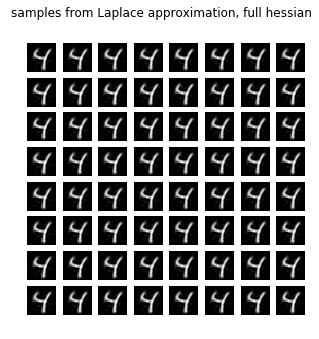

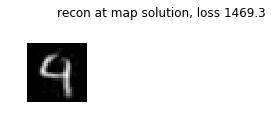

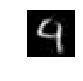

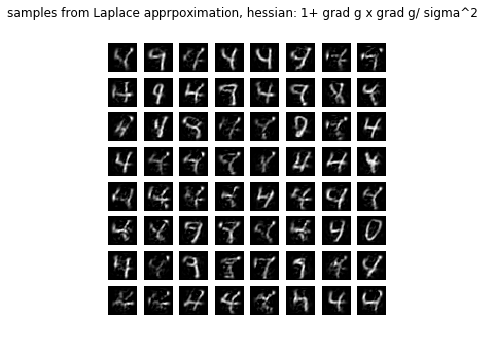

<Figure size 360x360 with 0 Axes>

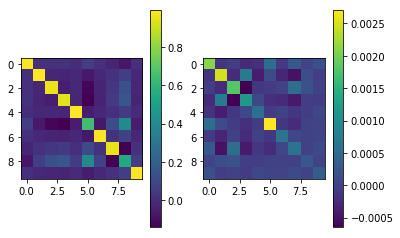

eigenvalues before and after inverse, full hessian
[array([[ 295.56754,  323.79993,  499.59866,  548.0393 , 1303.2059 ,
        1928.2512 , 2408.4624 , 2883.6624 , 4263.6104 , 6316.3467 ]],
      dtype=float32), array([[0.00015832, 0.00023454, 0.00034678, 0.0004152 , 0.0005186 ,
        0.00076734, 0.00182469, 0.00200161, 0.00308833, 0.00338332]])]


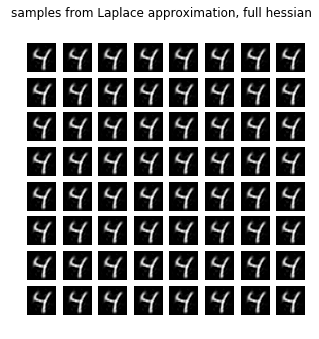

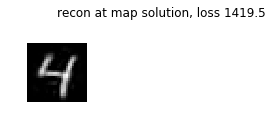

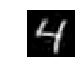

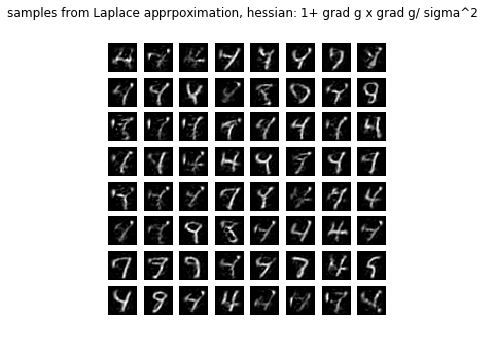

<Figure size 360x360 with 0 Axes>

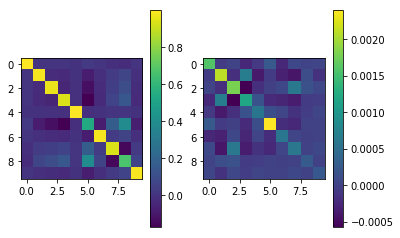

eigenvalues before and after inverse, full hessian
[array([[ 329.25522,  390.76392,  505.37305,  642.30615, 1251.9392 ,
        2089.7246 , 3148.4846 , 4194.1494 , 4512.867  , 5780.151  ]],
      dtype=float32), array([[0.00017301, 0.00022159, 0.00023843, 0.00031761, 0.00047853,
        0.00079876, 0.00155689, 0.00197874, 0.00255909, 0.00303716]])]


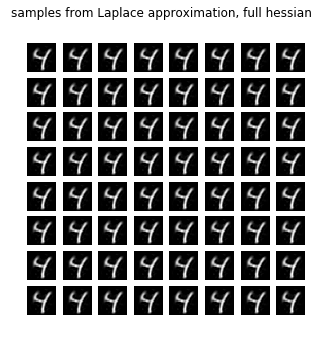

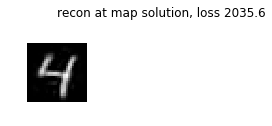

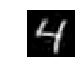

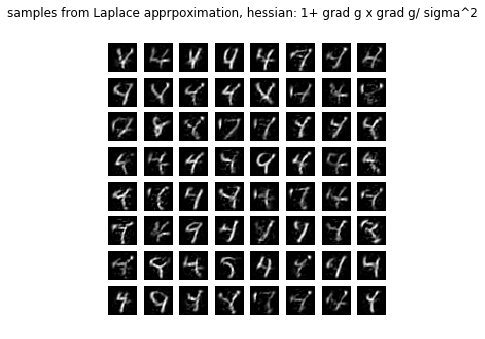

<Figure size 360x360 with 0 Axes>

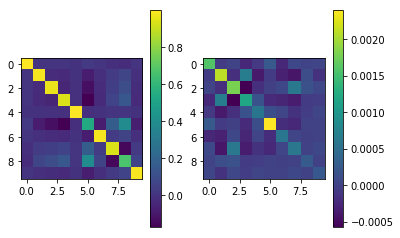

eigenvalues before and after inverse, full hessian
[array([[ 329.25522,  390.76392,  505.37305,  642.30615, 1251.9392 ,
        2089.7246 , 3148.4846 , 4194.1494 , 4512.867  , 5780.151  ]],
      dtype=float32), array([[0.00017301, 0.00022159, 0.00023843, 0.00031761, 0.00047853,
        0.00079876, 0.00155689, 0.00197874, 0.00255909, 0.00303716]])]


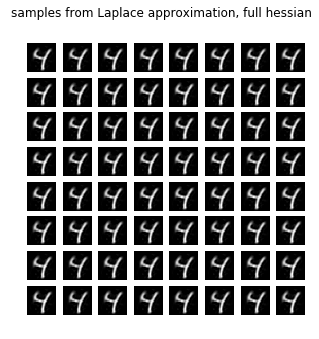

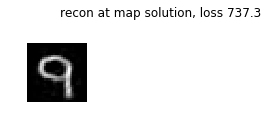

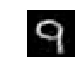

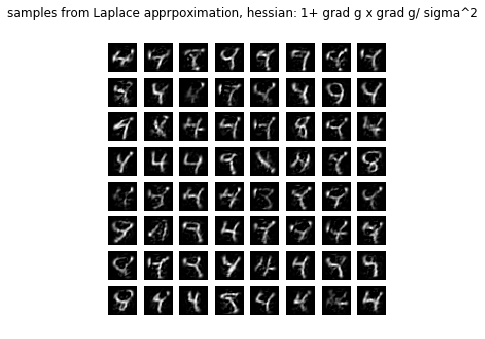

<Figure size 360x360 with 0 Axes>

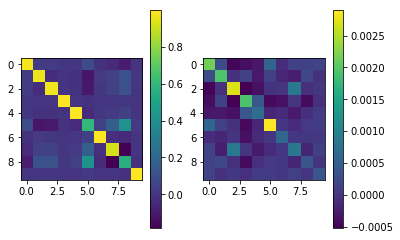

eigenvalues before and after inverse, full hessian
[array([[ 279.96597,  295.79144,  472.9282 ,  497.15036,  622.2537 ,
        1505.4579 , 1954.3016 , 2864.6968 , 4806.72   , 5976.8223 ]],
      dtype=float32), array([[0.00016731, 0.00020804, 0.00034908, 0.00051169, 0.00066425,
        0.00160706, 0.00201146, 0.00211449, 0.00338076, 0.00357186]])]


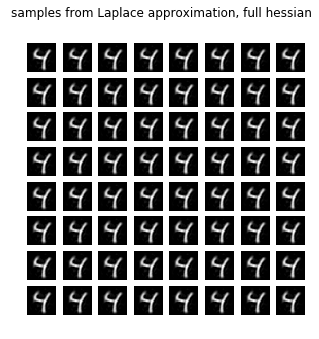

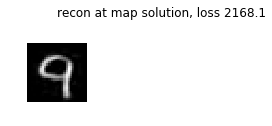

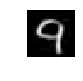

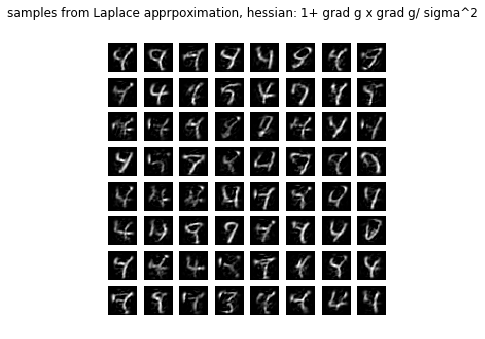

<Figure size 360x360 with 0 Axes>

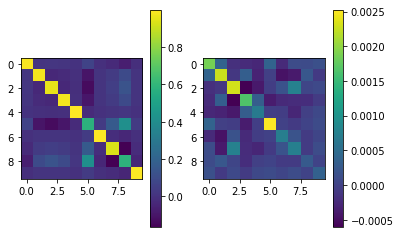

eigenvalues before and after inverse, full hessian
[array([[ 302.79645,  340.4805 ,  404.1211 ,  606.9125 ,  821.4269 ,
        1518.1434 , 1977.6283 , 2930.4229 , 5448.519  , 5482.971  ]],
      dtype=float32), array([[0.00018238, 0.00018354, 0.00034125, 0.00050566, 0.0006587 ,
        0.00121739, 0.00164768, 0.00247451, 0.00293702, 0.00330255]])]


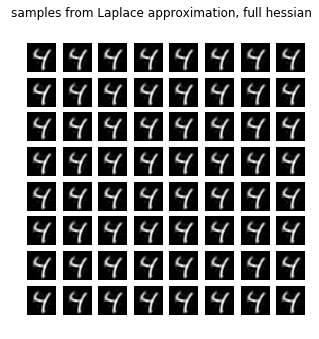

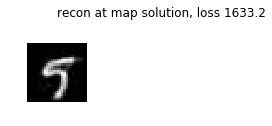

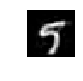

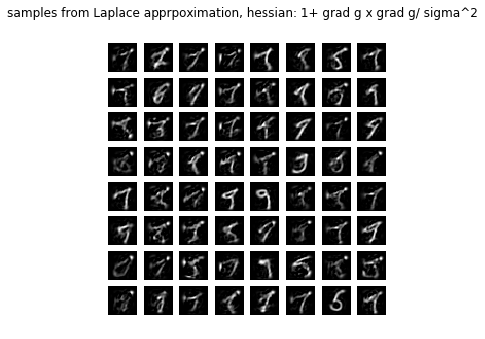

<Figure size 360x360 with 0 Axes>

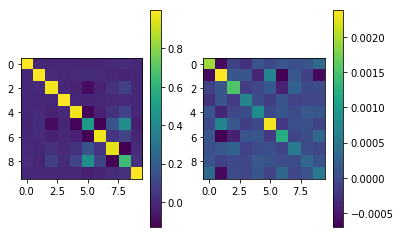

eigenvalues before and after inverse, full hessian
[array([[ 270.0749 ,  447.03912,  562.2821 ,  678.5729 , 1258.5518 ,
        1302.7478 , 1665.9392 , 2242.6946 , 3181.356  , 4399.3623 ]],
      dtype=float32), array([[0.00022731, 0.00031433, 0.00044589, 0.00060026, 0.00076761,
        0.00079456, 0.00147368, 0.00177847, 0.00223694, 0.00370268]])]


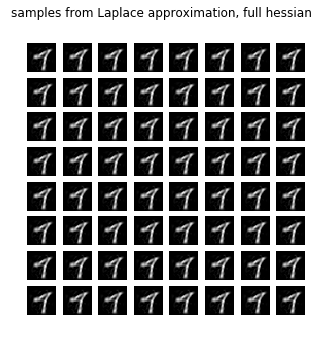

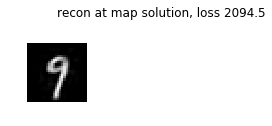

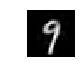

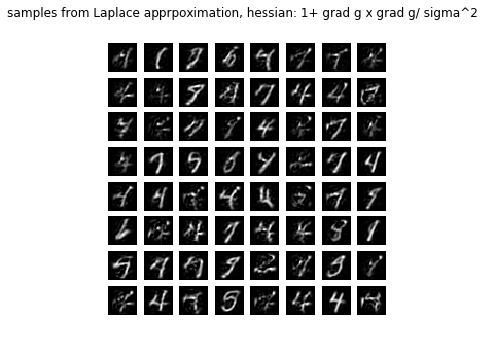

<Figure size 360x360 with 0 Axes>

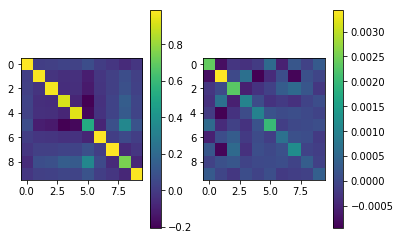

eigenvalues before and after inverse, full hessian
[array([[ 215.7159 ,  327.37067,  412.52216,  574.13824, 1279.0986 ,
        1365.5774 , 1837.0723 , 3068.643  , 3292.8608 , 4329.6123 ]],
      dtype=float32), array([[0.00023097, 0.00030369, 0.00032588, 0.00054434, 0.00073229,
        0.0007818 , 0.00174174, 0.00242411, 0.00305464, 0.00463573]])]


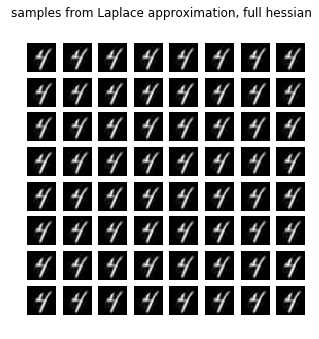

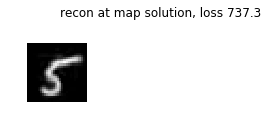

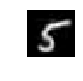

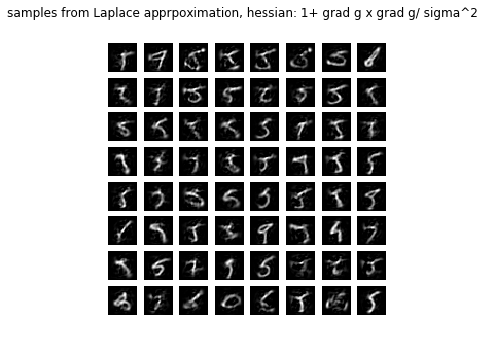

<Figure size 360x360 with 0 Axes>

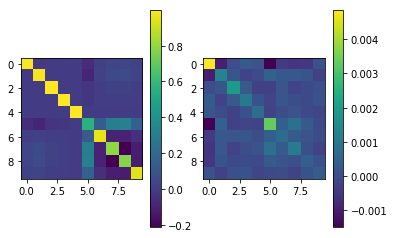

eigenvalues before and after inverse, full hessian
[array([[ 156.86053,  374.12003,  476.10394,  776.0871 ,  787.6871 ,
        1338.9464 , 1551.5988 , 2042.3889 , 3118.9053 , 5684.9727 ]],
      dtype=float32), array([[0.0001759 , 0.00032063, 0.00048962, 0.0006445 , 0.00074686,
        0.00126954, 0.00128851, 0.00210038, 0.00267294, 0.0063751 ]])]


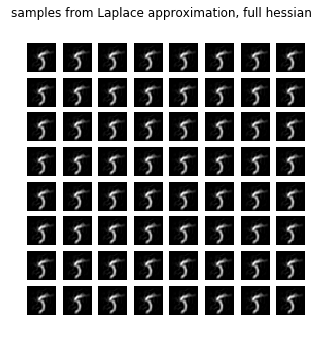

In [128]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

#order minimia
varis=[] 
l_minima_old=np.asarray(l_minima_old)
map_minima_old=np.asarray(map_minima_old)
order = np.argsort(l_minima_old)


for ii,ini_ in enumerate(map_minima_old[order]):
  
  # set MAP
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
 
  # Laplace approximation
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior:False})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})]

  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  figure(figsize=(5,5))
  #mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))

  ## plot sigma
  
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})

  plt.figure()
  subplot(1,2,1)
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
    
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False}))
  try:
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
  
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')


#do vae on corrupted data with mean of posterior set to MAP values
  if ii ==0:
    _ = sess.run(update4,feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior: False})   
    lrate=1e-2
    elbo_2_loss=[]
    for ii in range(2000):
      _, ll = sess.run([opt_op_elbo2, elbo],feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior: False})
      elbo_2_loss.append(ll)
      if ii%100==0:
        print(ll)
    plt.figure()
    plt.plot(elbo_2_loss)
    plt.show()
    
    elbo_var = sess.run(sigma_elbo,feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior: False})
    print('variance of VI', elbo_var)    


(1, 10, 10)


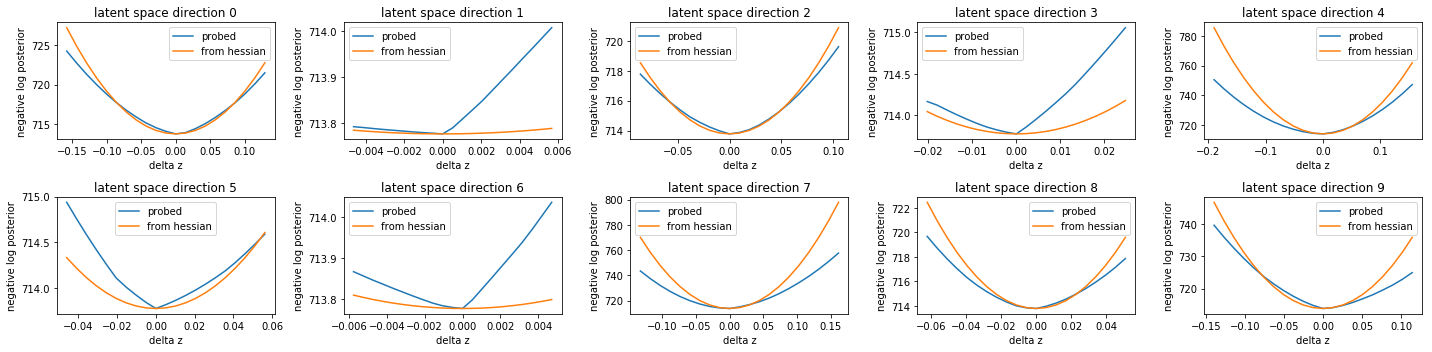

In [0]:
order     = np.argsort(l_minima_old)[0]
# testing Hessian
for ii,ini_ in enumerate([map_minima_old[order]]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], nvp_prior:False})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True, nvp_prior:False})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior:False})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  print(GN_hessian.shape)
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B = measured_hessian[0,nn,nn]
    GN = GN_hessian[0,nn,nn]
    elbo_v = 1./elbo_var[0,nn]**2
    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(21):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.01*(jj-11))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new, nvp_prior:False})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new, nvp_prior:False})
      losses.append(-ll)
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],losses,label='probed')
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+B*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from hessian')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+elbo_v*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from VI', color='tomato')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+GN*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.legend()
    plt.xlabel('delta z')
    plt.ylabel('negative log posterior')
    plt.tight_layout()


W0505 20:45:53.899823 140256009533312 legend.py:1289] No handles with labels found to put in legend.


(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)


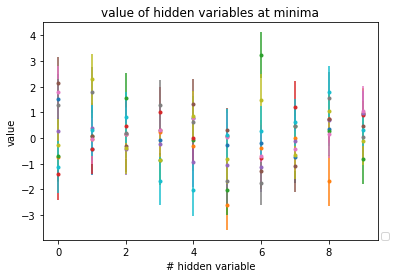

In [0]:
varis=np.asarray(varis)
map_minima_old=np.asarray(map_minima_old)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima_old)):
  print(map_minima_old.shape)
  yerr_= np.sqrt(varis[ii,0])
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima_old[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

**do vae on corrupted data with mean of posterior set to MAP values**

---

